# Previsão de Falência Financeira

* Esse dataset apresenta dados de empresas segundo regulações econômicas da época,
que podem ou não enfrentar um processo de falência. Aqui usaremos de vários modelos preditivos para mensurar, quantas delas podem ou não enfrentar esta situação adversa no futuro. 

##### A seguir, as bibliotecas importadas para esse script. Nesse projeto usaremos os seguintes algoritmos de ML:
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* CatBoost Classifier
* XGBoost Classifier
##### Para os hipermarâmetros:
* RandomizedSearchCV
* GridSearchCV

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore")

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report

from hyperopt import hp, Trials, fmin, tpe, STATUS_OK
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

* Vamos conhecer melhor o dataset e se familiarizar com suas particularidades.

In [3]:
bdata = pd.read_csv("data_bankruptcy.csv", sep=',')
bdata.head()

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.457733    
4                                           0.522298    

    Operating Gross Margin   Realized Sales Gross Margin  \
0                 0.601457                      0.601457   
1                 0.610235                      0.610235   
2                 0.601450                      0.601364   
3                 0.583541                      0.583541   
4                 0.598783                      0.598783   

    Operating Profit Rate   Pre-tax net Interest Rate  \
0                0.998969                    0.796887   
1                0.998946                    0.797380   
2                0.998857                    0.796403   
3                0.998700                    0.796967   
4                0.998973                    0.797366   

    After-tax net Interest Rate   Non-industry income and expenditure/revenue  \
0                      0.808809                                      0.302646   
1                      0.809301                                      0.303556   
2                      0.808388                                      0.302035   
3                      0.808966                                      0.303350   
4                      0.809304                                      0.303475   

   ...   Net Income to Total Assets   Total assets to GNP price  \
0  ...                     0.716845                    0.009219   
1  ...                     0.795297                    0.008323   
2  ...                     0.774670                    0.040003   
3  ...                     0.739555                    0.003252   
4  ...                     0.795016                    0.003878   

    No-credit Interval   Gross Profit to Sales  \
0             0.622879                0.601453   
1             0.623652                0.610237   
2             0.623841                0.601449   
3             0.622929                0.583538   
4             0.623521                0.598782   

    Net Income to Stockholder's Equity   Liability to Equity  \
0                             0.827890              0.290202   
1                             0.839969              0.283846   
2                             0.836774              0.290189   
3                             0.834697              0.281721   
4                             0.839973              0.278514   

    Degree of Financial Leverage (DFL)  \
0                             0.026601   
1                             0.264577   
2                             0.026555   
3                             0.026697   
4                             0.024752   

    Interest Coverage Ratio (Interest expense to EBIT)   Net Income Flag  \
0                                           0.564050                   1   
1                                           0.570175                   1   
2                                           0.563706                   1   
3                                           0.564663                   1   
4                        

In [4]:
bdata.shape

(6819, 96)

* Pré-limpeza e formatação, o arquivo apresenta 6819 registros. Cada registro apresenta 95 atributos independentes e uma classe dependente.

In [5]:
bdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

* Todos os dados são float ou int. Então vamos seguir com o entendimento do dataset, vamos procurar por valores nulos ou duplicados.

In [6]:
#Check de valores nulos
print(bdata.isnull().sum().max())

#Check de valores duplicados
print(bdata.duplicated().sum().max())

0
0


* Vamos seguir, com a classe preditória e seus registros.

In [7]:
print(round(bdata['Bankrupt?'].value_counts()[0]/len(bdata) * 100,2), '% é Financeiramente Estável')
print(round(bdata['Bankrupt?'].value_counts()[1]/len(bdata) * 100,2), '% é Financeiramente Instável')
print(bdata['Bankrupt?'].value_counts())

96.77 % é Financeiramente Estável
3.23 % é Financeiramente Instável
0    6599
1     220
Name: Bankrupt?, dtype: int64


[Text(0, 0.5, 'Registros'), Text(0.5, 0, 'Situação')]

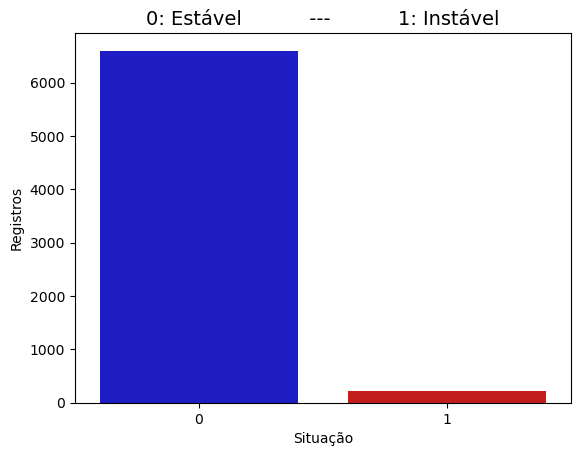

In [8]:
# Vamos por a informação acima num gráfico.
colors = ["#0101DF", "#DF0101"]

ax = sns.countplot('Bankrupt?', data=bdata, palette=colors)
plt.title('0: Estável           ---           1: Instável', fontsize=14)
ax.set(ylabel='Registros', xlabel='Situação')

* Aqui fica claro o quão desbalanceado este dataset está. Retornaremos a isso mais na frente.

## EDA

* Vamos iniciar nossa analise com alguns graficos e verificar a correlação entre as categorias do dataset.

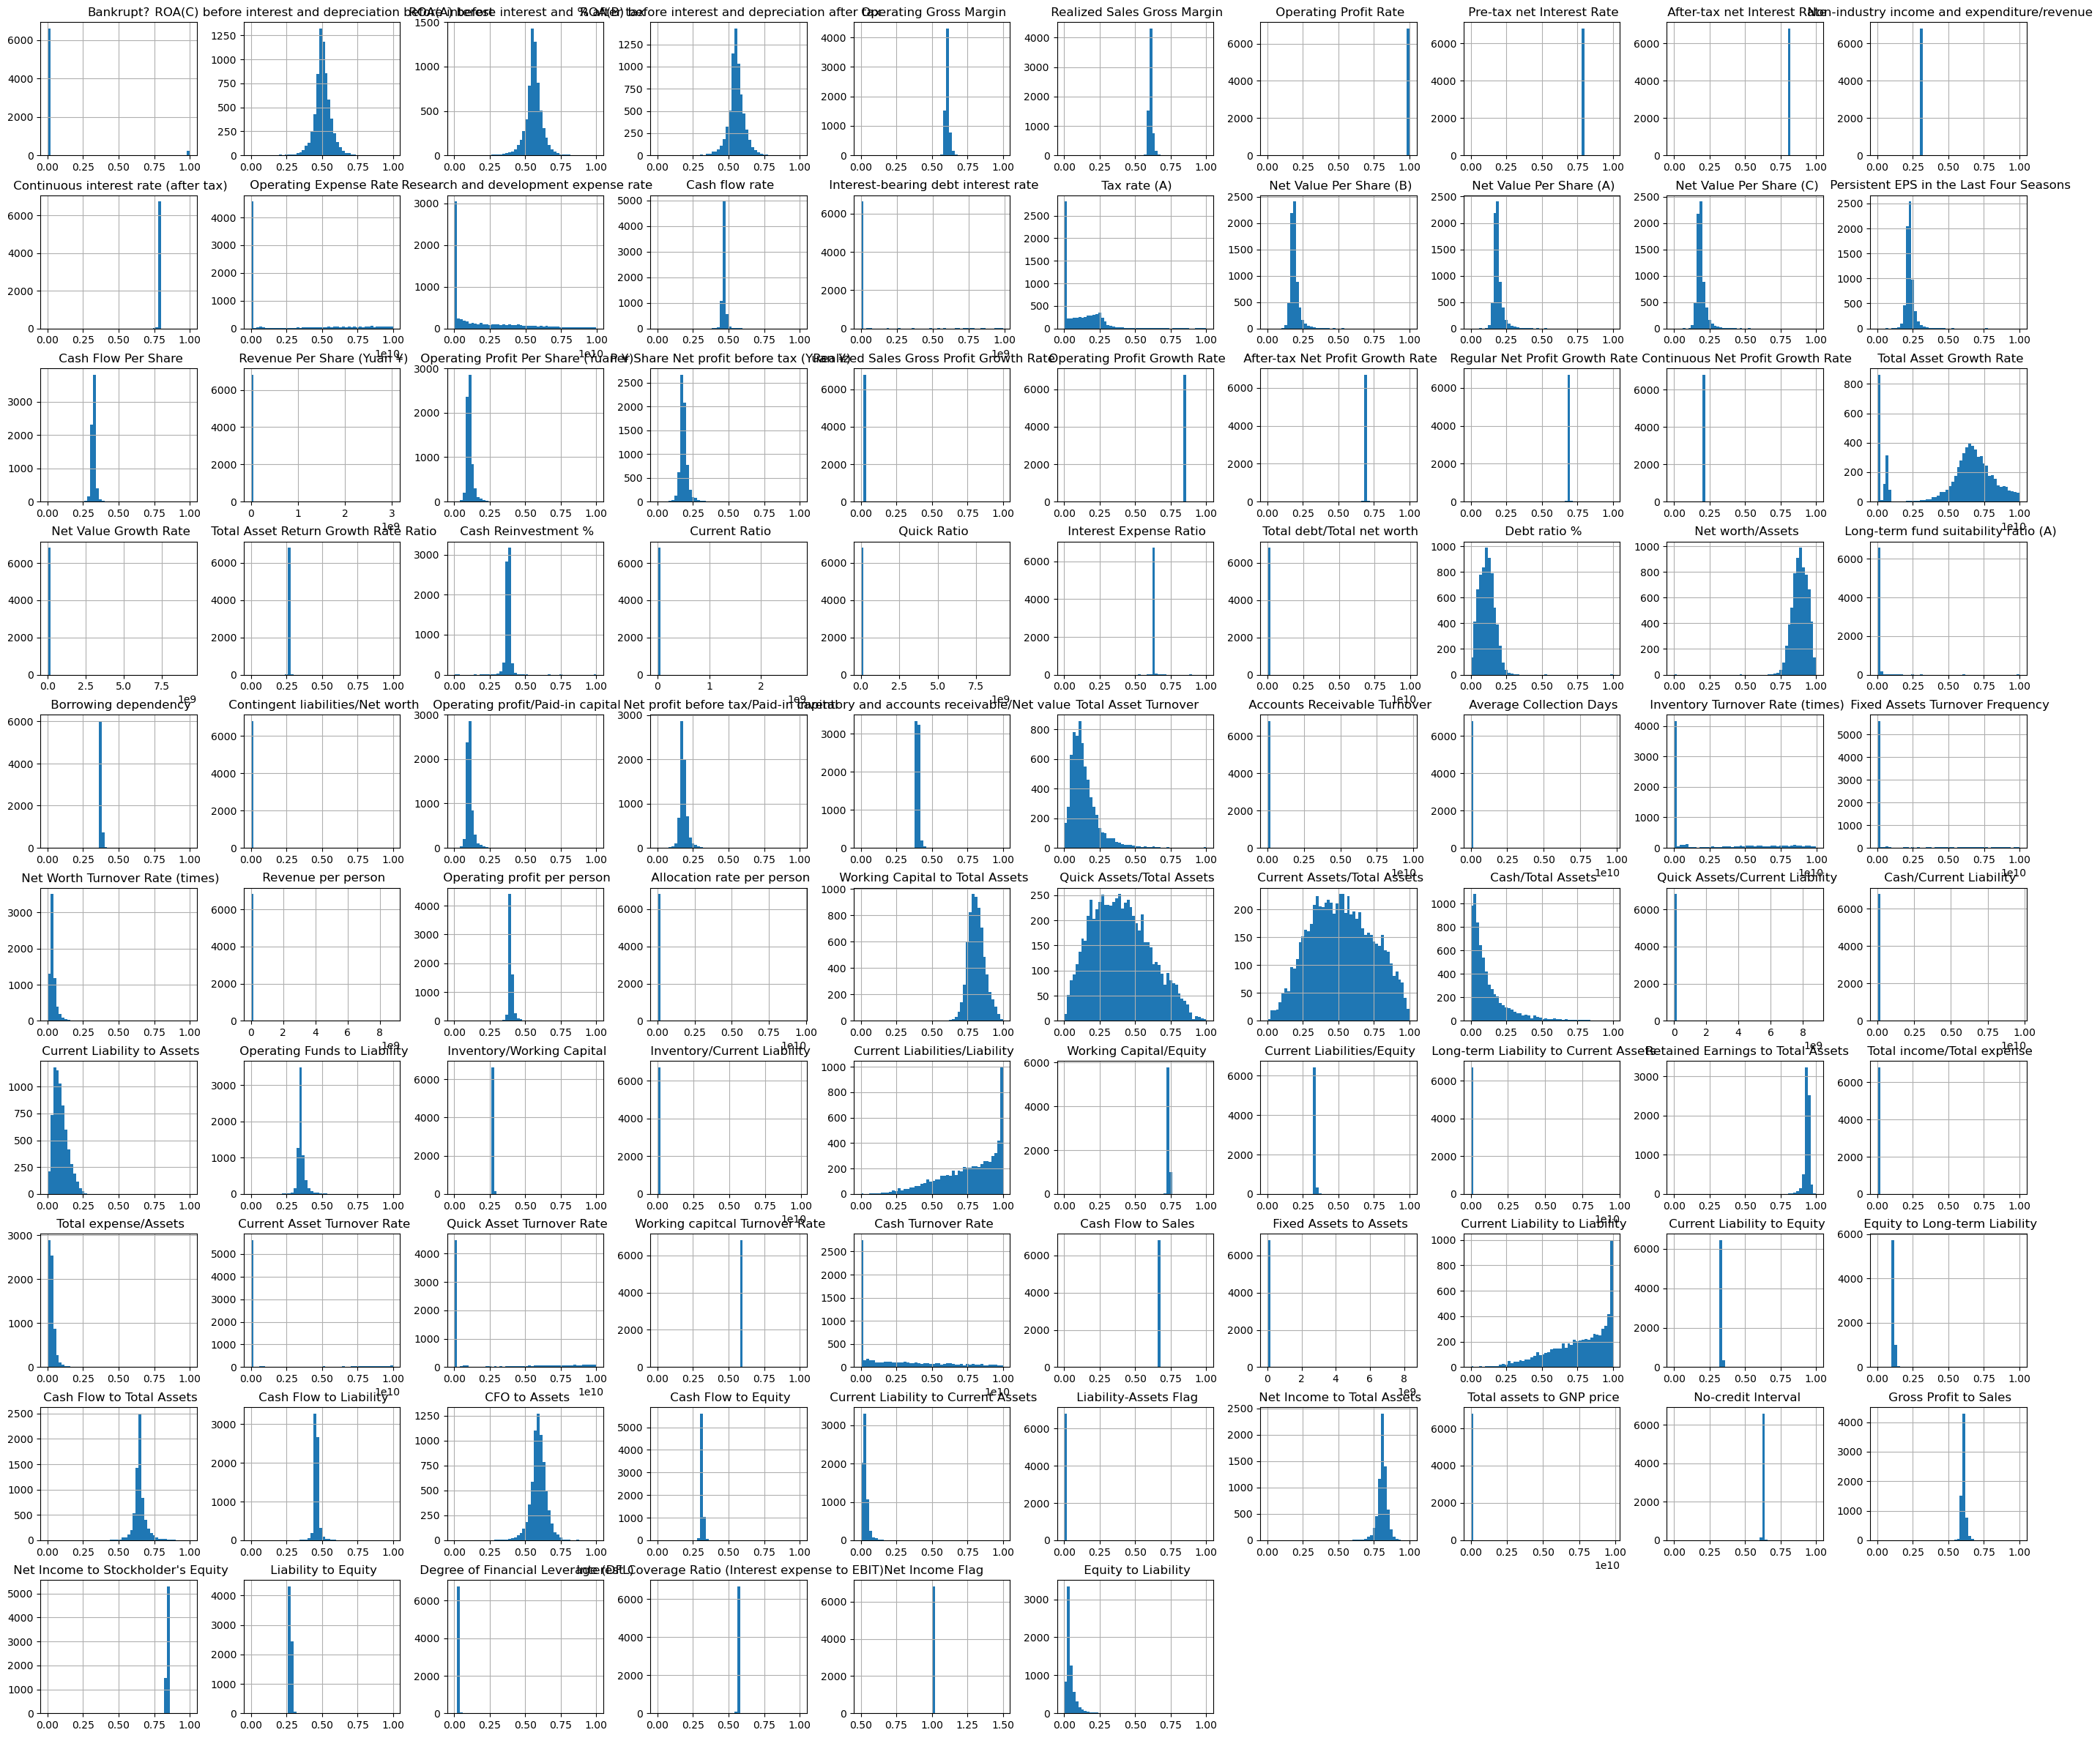

In [9]:
bdata.hist(figsize = (35,30), bins = 50)
plt.show()

* Alguns ajustes vão ser necessários para tornar esses dados mais próximos de uma distribuição normal, de modo a aumentar a performasse dos nossos modelos.

<AxesSubplot:>

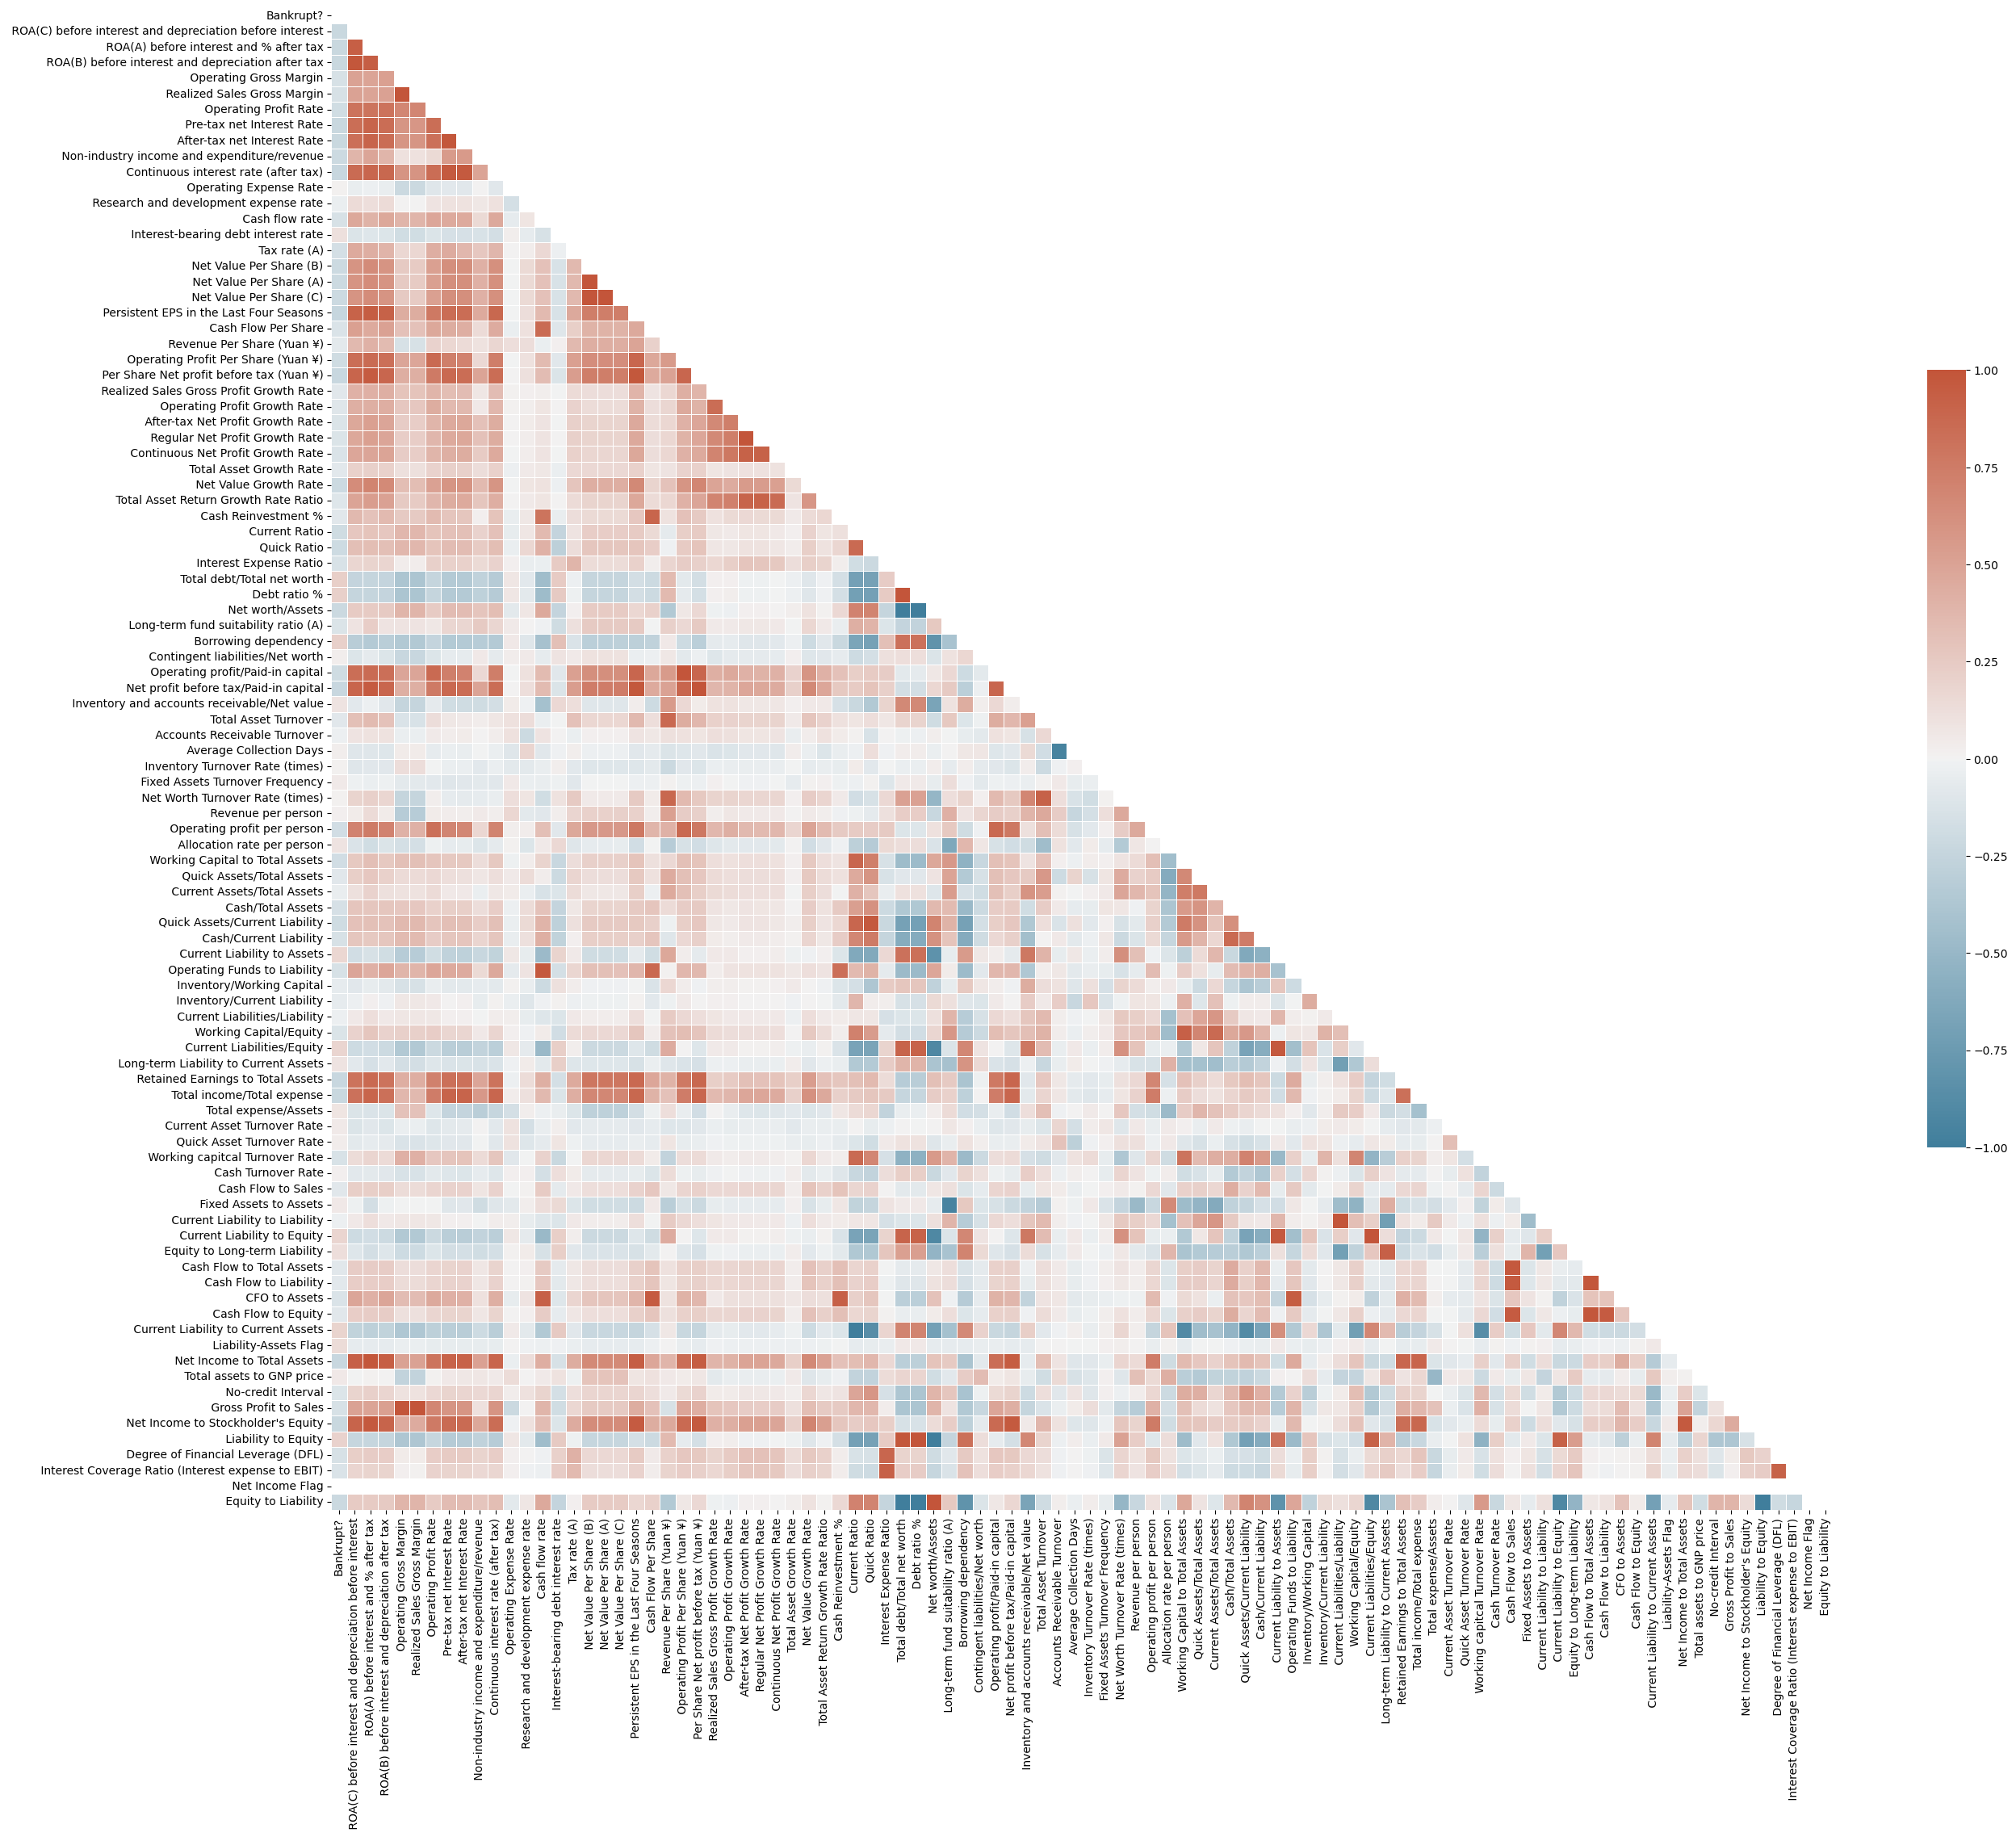

In [10]:
# Heatmap Correlação (Spearman)

plt.figure(figsize=(30,25))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(bdata.corr('spearman'), dtype=bool))
sns.heatmap(bdata.corr('spearman'), annot=False, mask=mask, cmap=cmap, vmax=1, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

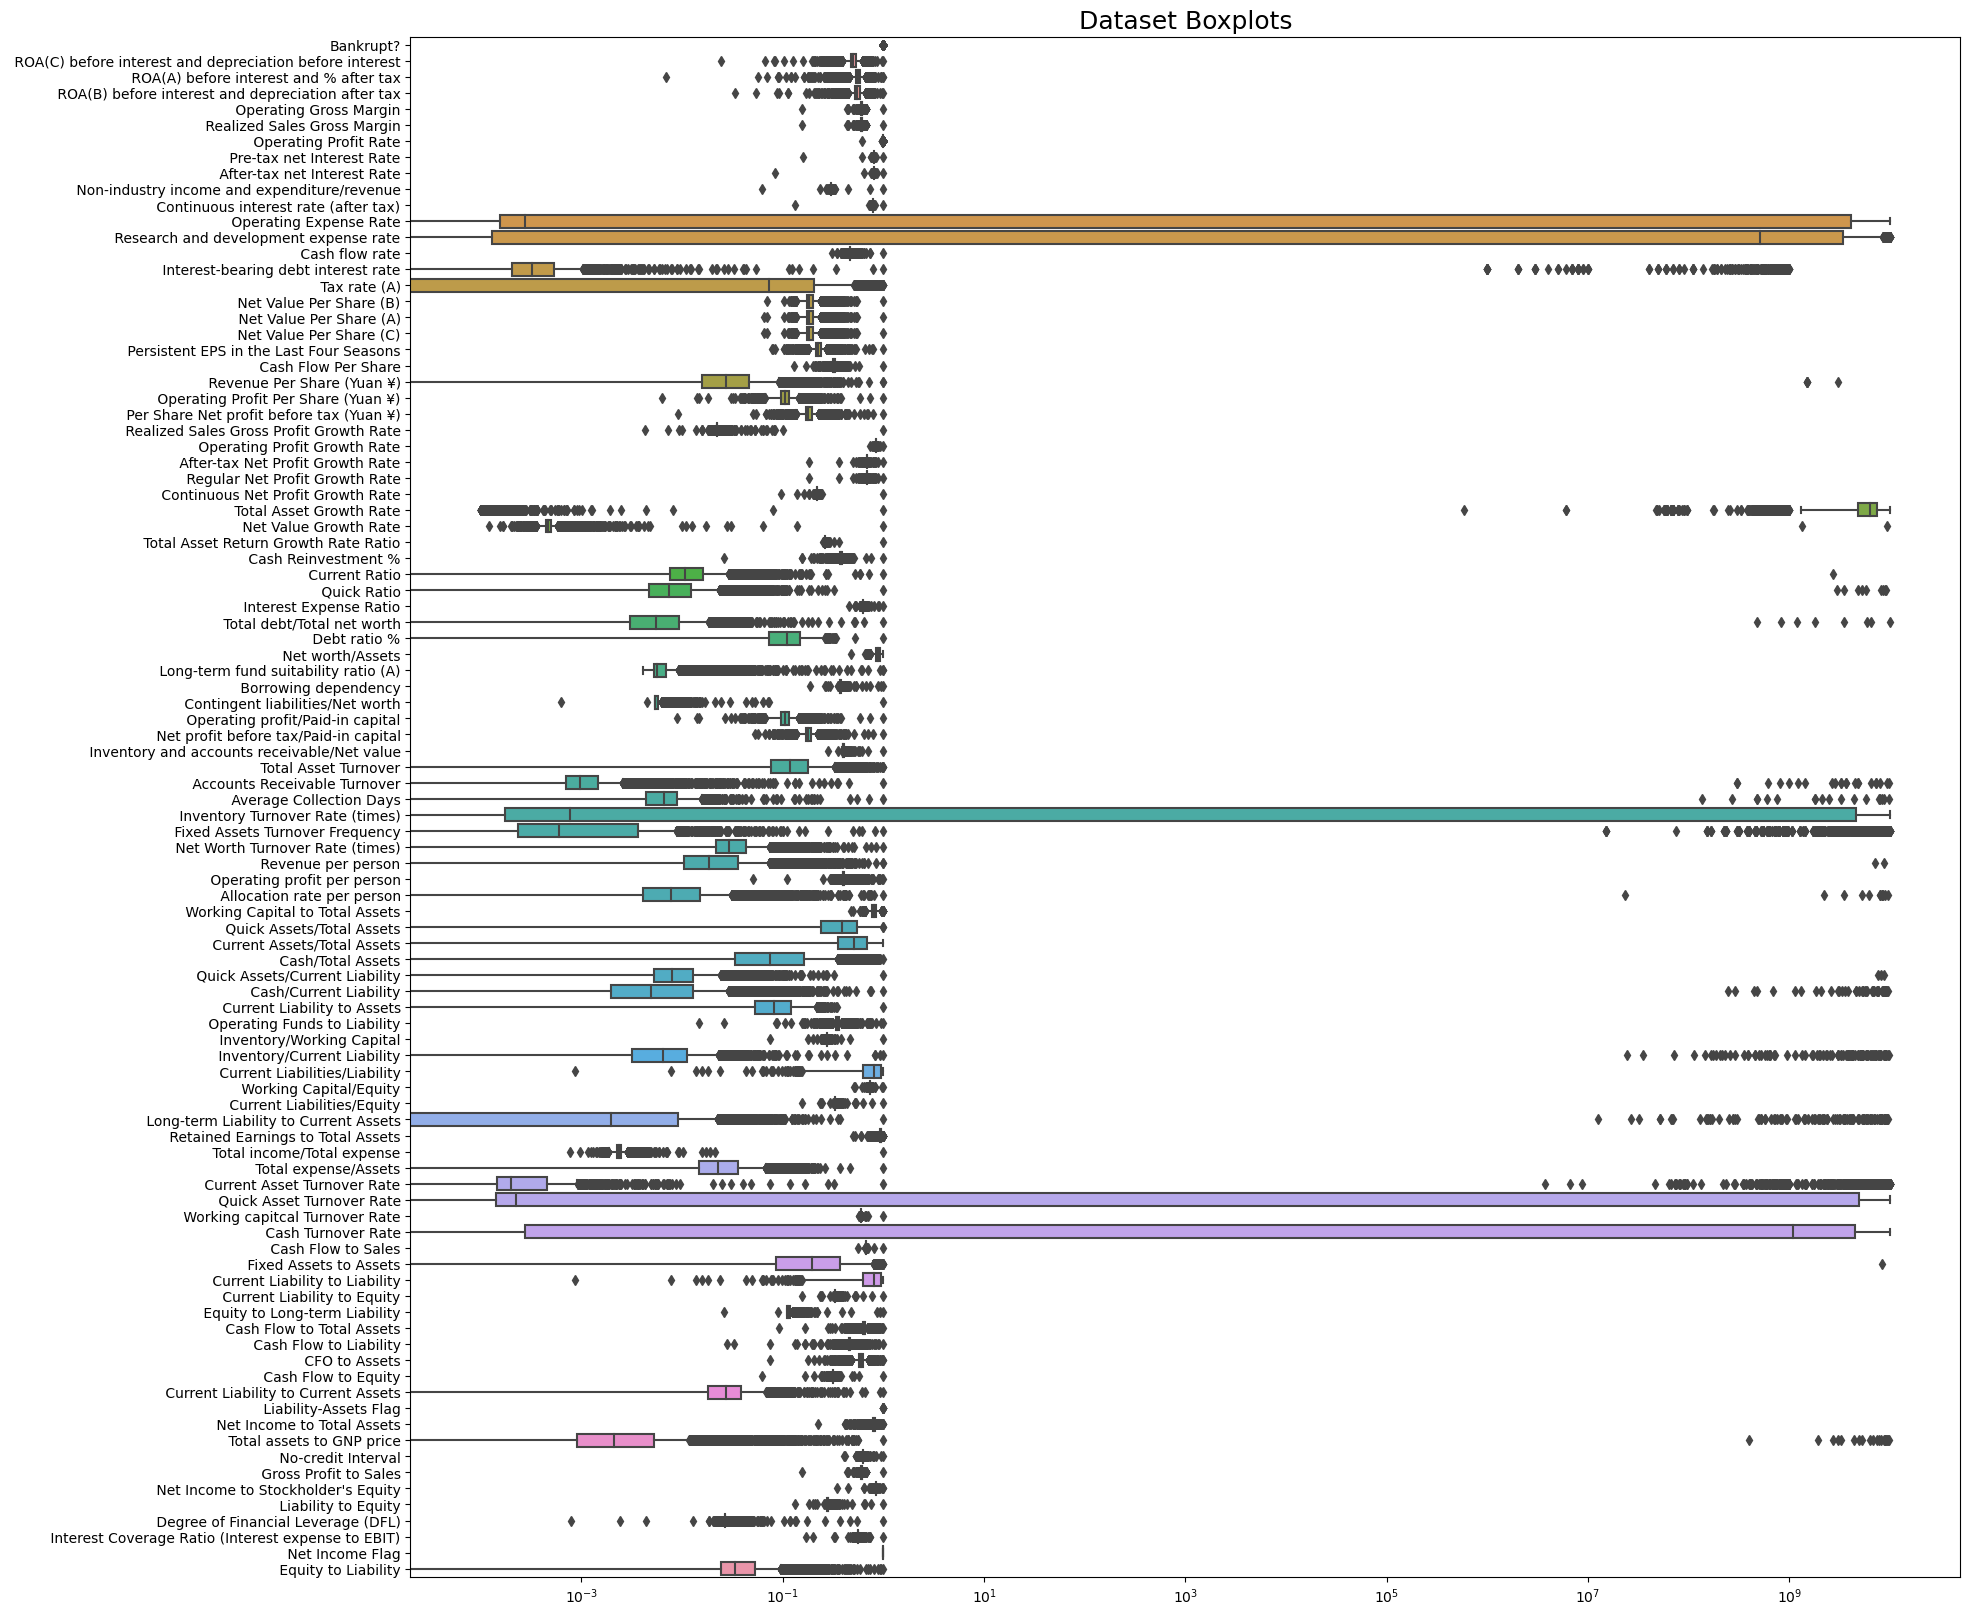

In [11]:
# Plot dos Atributos Numéricos

plt.figure(figsize = (20,20))
ax = sns.boxplot(data = bdata, orient="h")
ax.set_title('Dataset Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

* Dado a natureza dos dados, é impossível tirar conclusões acerca dos atributos apenas por análise, vamos criar modelos e ver que pontos estão impactando mais na performance, então vamos poder ter uma análise mais profunda.
* É possível notar vários outliers no dataset, vamos cuidar disso, e tentar tornar os dados mais normalizados.
* Para esse projeto, vou optar por excluir os outliers, no entanto, poderia substituir os valores pela média dos valores, a depender da importância desses registros para o objetivo do modelo preditivo que estamos construindo. 

In [12]:
# Vamos cuidar aqui para eliminar os outliers que estão atrapalhando o dataset.
def outliers_removal(cat,cat_name,dataset):
    
    # Identificamos o 1º quartil e 3º quartil

    q1, q3 = np.percentile(cat, 25), np.percentile(cat, 75)
    cat_qrt = q3 - q1
    
    
    out_cat_drop = cat_qrt * 1.5
    cat_baixo, cat_topo = q1 - out_cat_drop, q3 + out_cat_drop

    dataset = dataset.drop(dataset[(dataset[cat_name] > cat_topo) | (dataset[cat_name] < cat_baixo)].index)

    return dataset

for cat in bdata:
    bdata2 = outliers_removal(bdata[cat],str(cat),bdata)

In [13]:
bdata2.shape

(6270, 96)

* 8,06% dos dados foram removidos para suavisar a curva de dados do arquivo.

In [14]:
# Divisão dos dados
cat_data = bdata2.drop(['Bankrupt?'], axis = 1)
class_data = bdata2['Bankrupt?']

In [15]:
# Passamos os dados categóricos para base logarítmica
def log_trans(data):
    
    for col in data:
        skew = data[col].skew()
        if skew > 0.5 or skew < -0.5:
            data[col] = np.log1p(data[col])
        else:
            continue
            
    return data

cat_data2 = log_trans(cat_data)

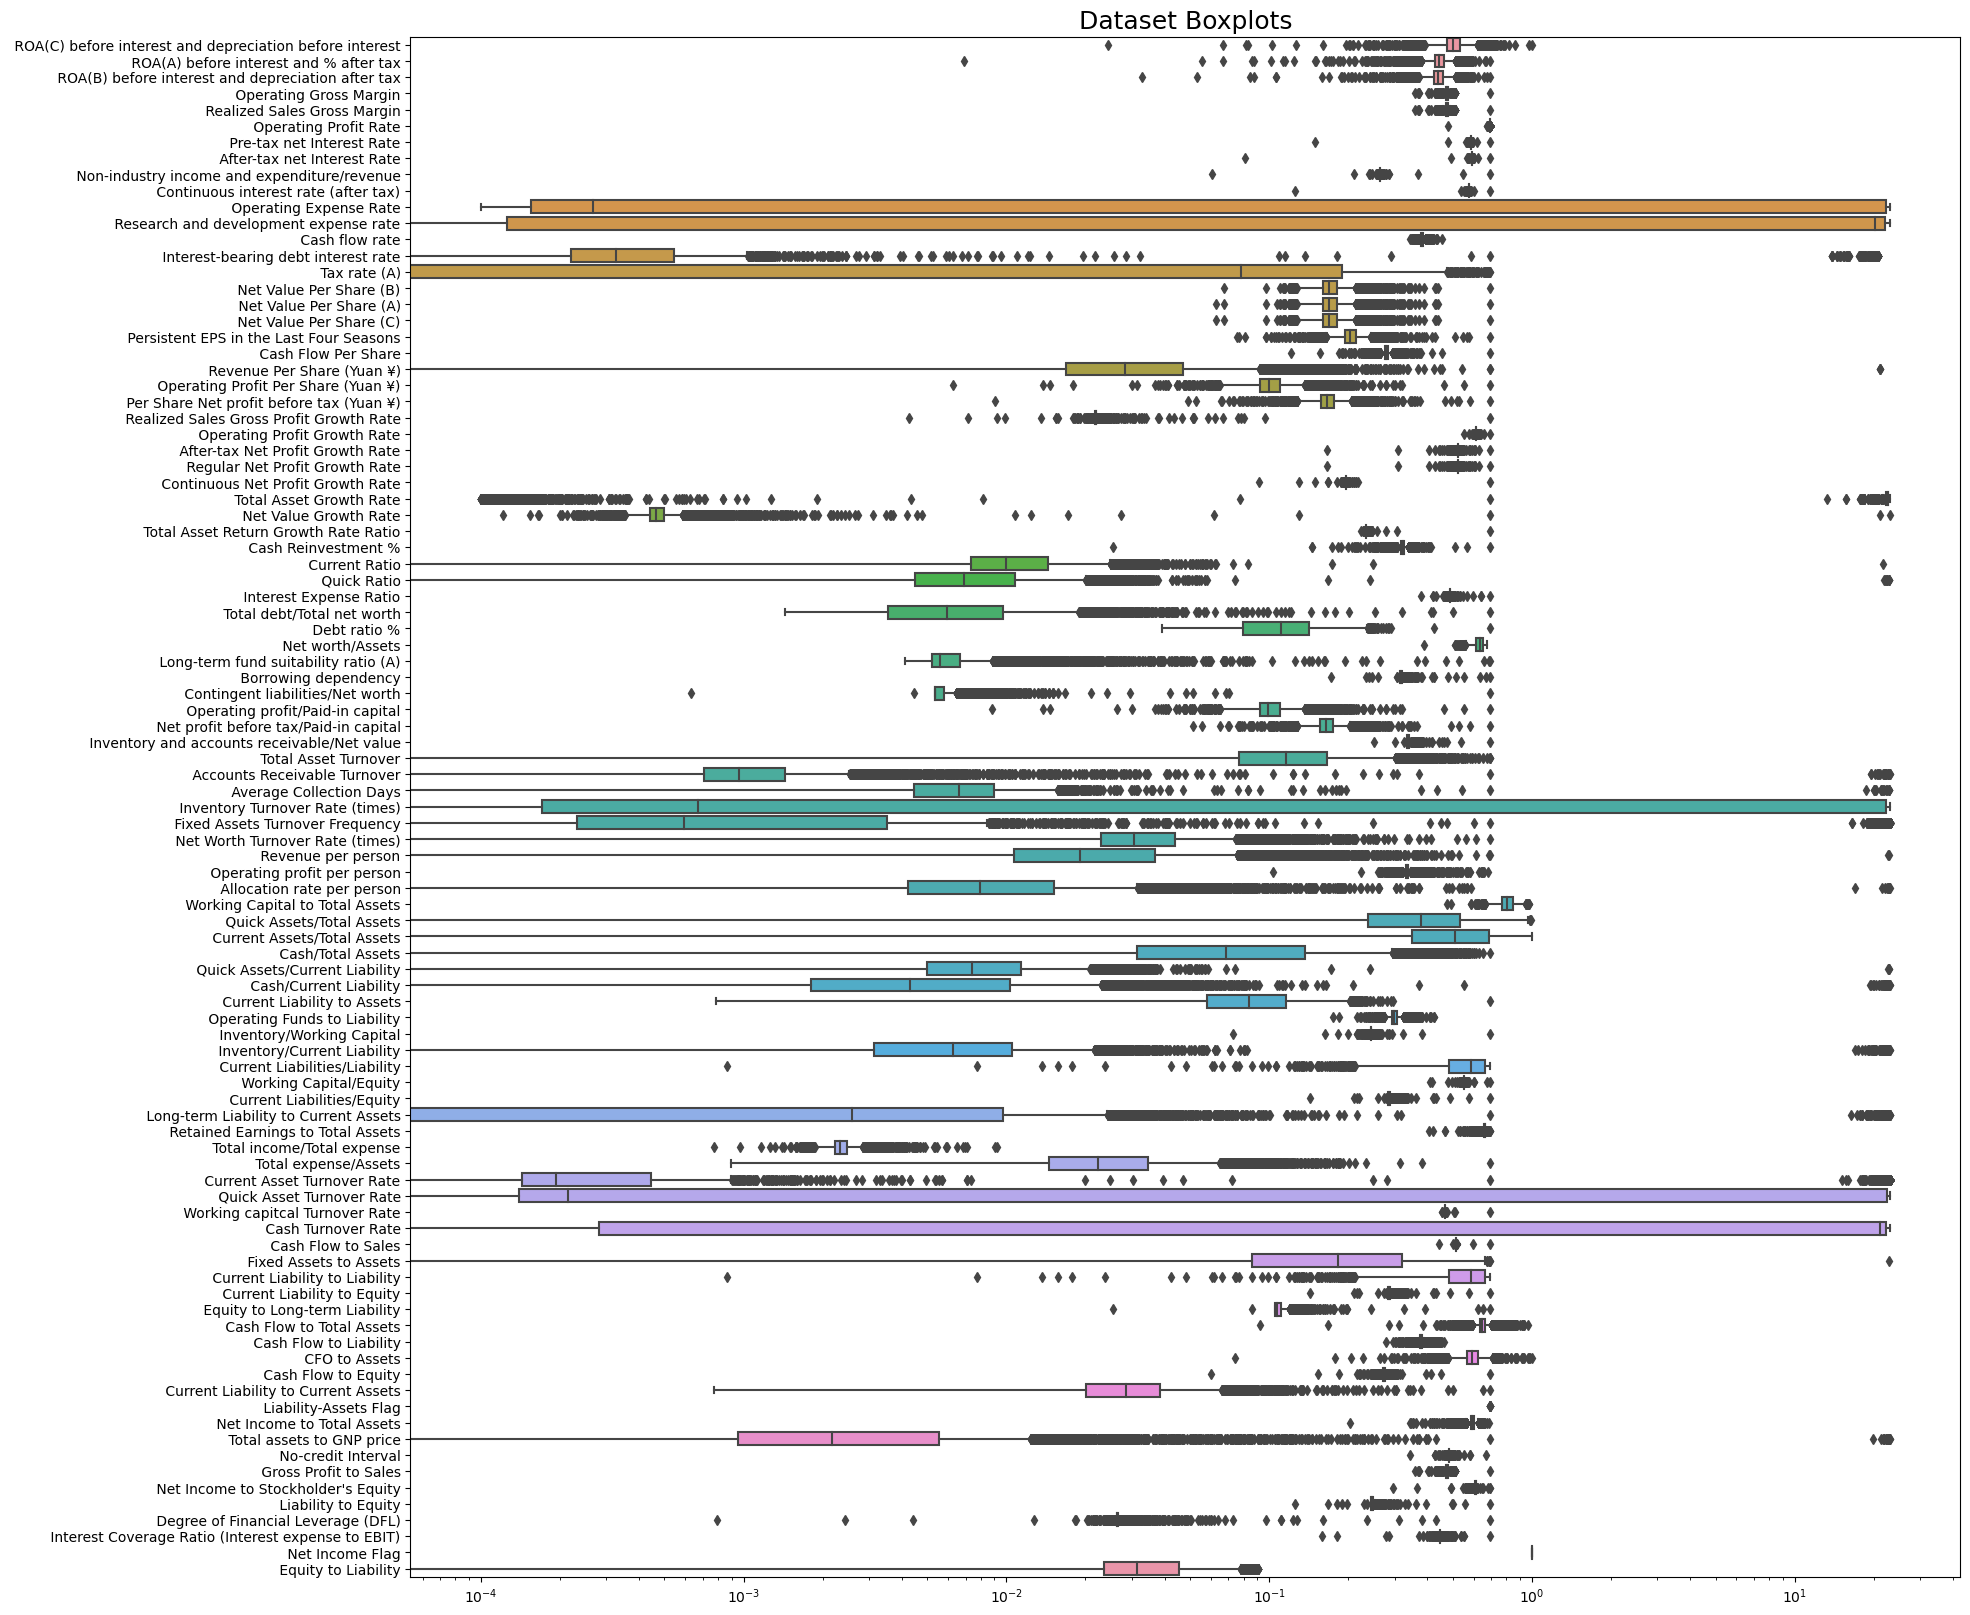

In [16]:
plt.figure(figsize = (20,20))
ax = sns.boxplot(data = cat_data2, orient="h")
ax.set_title('Dataset Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

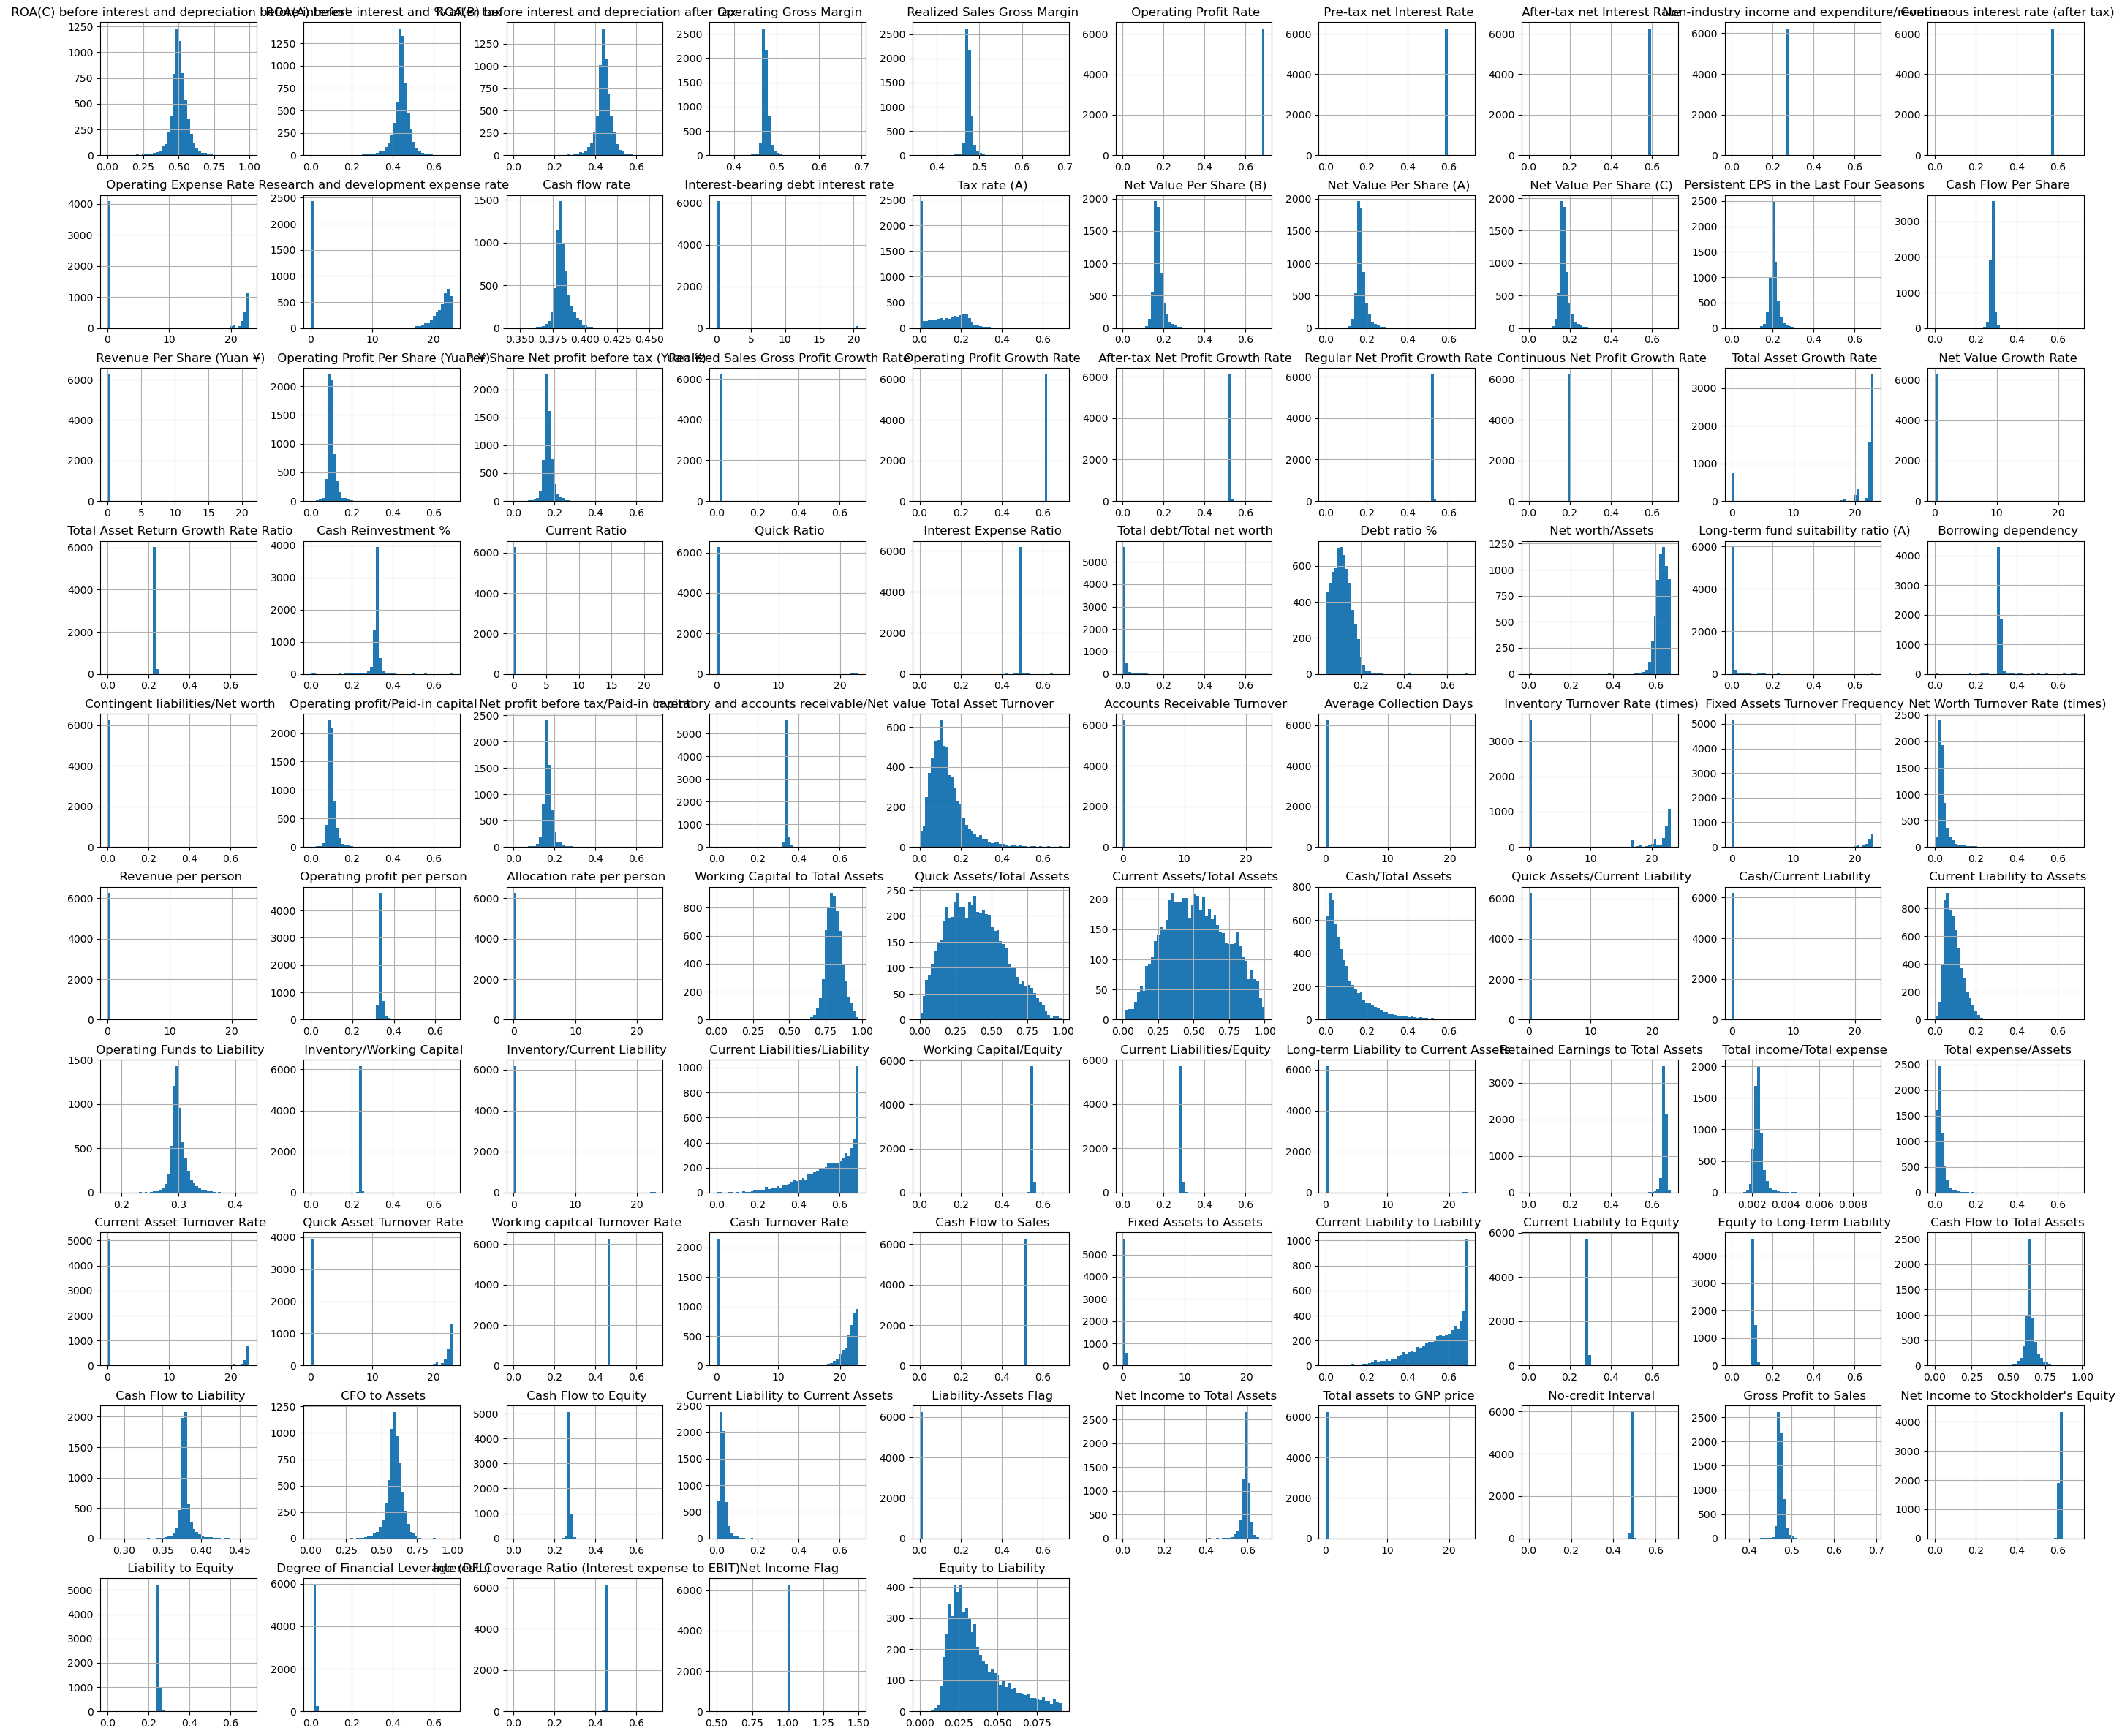

In [17]:
cat_data2.hist(figsize = (35,30), bins = 50)
plt.show()

* Acredito que os dados estão relativamente normalizados e balanceados. Vários dos gráficos acima assumiram a forma de sino desejada para uma distribuição mais normalizada. Vamos seguir com a construção dos modelos.

In [18]:
# Divisão train/test do dataset
x_train,x_test,y_train,y_test  = train_test_split(cat_data2,
                                              class_data,
                                              test_size=0.3,
                                              stratify = class_data,
                                              random_state = 42)

In [19]:
# Vamos criar num dicionário com os modelos que vamos utilizar nos testes.
modelos_comp = {
    "Logistic Regression" : LogisticRegression(random_state = 42),
    "Random Forest Classifier" : RandomForestClassifier(random_state = 42),
    "XGB Classifier" : XGBClassifier(random_state = 42),
    "CatBoost Classifier" : CatBoostClassifier(random_state = 42, verbose = 0),
    "Decision Tree Classifier" : DecisionTreeClassifier(random_state = 42)
}

In [20]:
# Aqui criamos uma função para treinar e valorar os modelos.
def fit_score(modelo, x_treino, x_teste, y_treino, y_teste):
    np.random.seed(42)
    valor_modelo = {}
    
    # Laço para rodar os modelos.
    for nome, modelo in modelo.items():
        # Treinamento
        modelo.fit(x_treino, y_treino)
        # Valoração dos modelos
        valor_modelo[nome] = modelo.score(x_teste,y_teste)
    return valor_modelo

In [21]:
avaliacao_modelos = fit_score(modelo=modelos_comp,
                        x_treino=x_train,
                        x_teste=x_test,
                        y_treino=y_train,
                        y_teste=y_test)

# Salvamos o resultado num Dataframe
comparativos_modelo = pd.DataFrame(avaliacao_modelos, index=["Accuracy"])
comparativos_modelo

Logistic Regression  Random Forest Classifier  XGB Classifier  \
Accuracy             0.967039                  0.968102        0.969165   

          CatBoost Classifier  Decision Tree Classifier  
Accuracy             0.969697                  0.944179

* Até aqui o modelos performaram muito bem, então o arquivo aparenta estar normal. Vamos seguir com ajustes nos parâmetros dos modelos.

## Logistic Regression + RandomSearchCV


In [32]:
log_reg_rsparams = {"penalty": ['none', 'l2', 'l1', 'elasticnet'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'class_weight': ['balanced', None],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

rand_log_reg = RandomizedSearchCV(LogisticRegression(),log_reg_rsparams, n_iter=4)

modelrs_log_reg = rand_log_reg.fit(x_train, y_train)


In [33]:
# Melhores parâmetros
rand_log_reg.best_params_

{'solver': 'lbfgs', 'penalty': 'none', 'class_weight': 'balanced', 'C': 10}

In [40]:
tuners_log_reg = LogisticRegression(solver='lbfgs', 
                   penalty='none', 
                   class_weight='balanced', 
                   C=10,
                   n_jobs=-1)
modelrs2_log_reg = tuners_log_reg.fit(x_train, y_train)
log_reg_rsprev = modelrs2_log_reg.predict(x_test)

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1816
           1       0.14      0.80      0.24        65

    accuracy                           0.82      1881
   macro avg       0.56      0.81      0.57      1881
weighted avg       0.96      0.82      0.88      1881



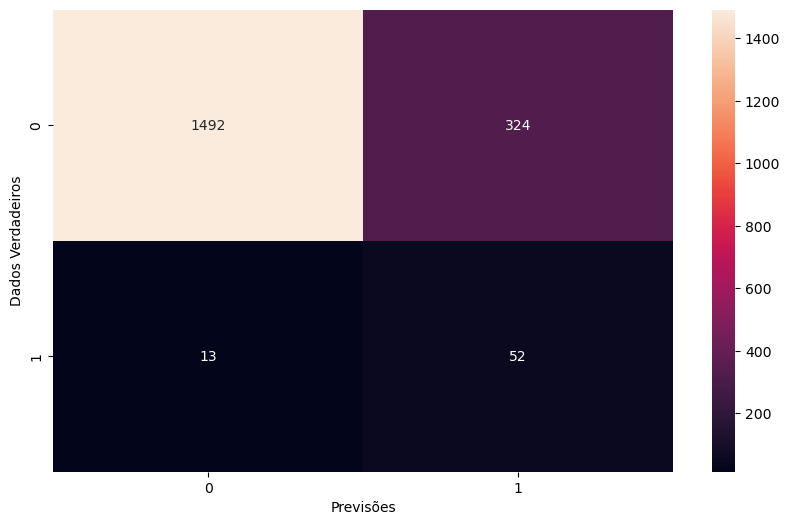

In [41]:
# Vamos por o resultado numa Matriz
def matrix_conf(y_val, pred):
    fix, ax = plt.subplots(figsize=(10,6))
    ax = sns.heatmap(confusion_matrix(y_val, pred),
                     annot=True,
                     cbar=True,
                     fmt="g");
    plt.xlabel("Previsões")
    plt.ylabel("Dados Verdadeiros")

print(classification_report(y_test, log_reg_rsprev))
matrix_conf(y_test, log_reg_rsprev) 

## Logistic Regression + GridSearchCV

In [42]:
log_reg_gsparams = {"penalty": ['none', 'l2', 'l1', 'elasticnet'],
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'class_weight': ['balanced', None],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid_log_reg = GridSearchCV(LogisticRegression(),log_reg_gsparams, n_jobs=-1)

modelgs_log_reg = grid_log_reg.fit(x_train, y_train)

In [43]:
# Melhores parâmetros
grid_log_reg.best_params_

{'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}

In [44]:

tunegrid_log_reg = LogisticRegression(solver='newton-cg', 
                   penalty='l2', 
                   class_weight=None, 
                   C=1,
                   n_jobs=-1)
modelgs2_log_reg = tunegrid_log_reg.fit(x_train, y_train)
log_reg_gsprev = modelgs2_log_reg.predict(x_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1816
           1       0.70      0.11      0.19        65

    accuracy                           0.97      1881
   macro avg       0.83      0.55      0.59      1881
weighted avg       0.96      0.97      0.96      1881



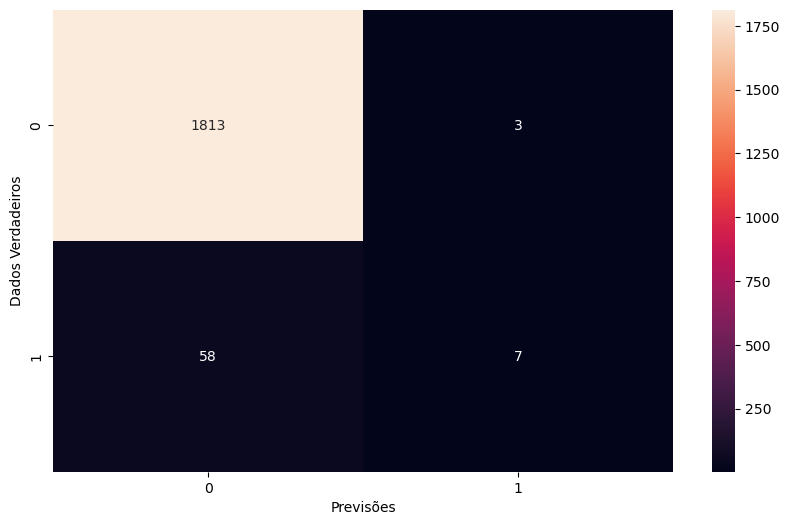

In [45]:
# Vamos por o resultado numa Matriz
print(classification_report(y_test, log_reg_gsprev))
matrix_conf(y_test, log_reg_gsprev) 

## Random Forest Classifier + RandomSearchCV

In [46]:
rfc_rsparams = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'class_weight' : ['balanced','balanced_subsample'],
              'criterion' : ['gini', 'entropy'],
              'bootstrap' : [True,False]}

rand_rfc = RandomizedSearchCV(RandomForestClassifier(),rfc_rsparams,n_iter=4)

rsmodel_rfc = rand_rfc.fit(x_train, y_train)

In [47]:
rand_rfc.best_params_


{'random_state': 42,
 'max_features': 'sqrt',
 'criterion': 'gini',
 'class_weight': 'balanced_subsample',
 'bootstrap': True}

In [52]:
rstune_rfc = RandomForestClassifier(random_state=42,
               max_features='sqrt',
                criterion='gini',
                class_weight='balanced_subsample',
                bootstrap=True)
modelrs2_rfc = rstune_rfc.fit(x_train, y_train)
rfc_rsprev = modelrs2_rfc.predict(x_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1816
           1       0.56      0.15      0.24        65

    accuracy                           0.97      1881
   macro avg       0.76      0.57      0.61      1881
weighted avg       0.96      0.97      0.96      1881



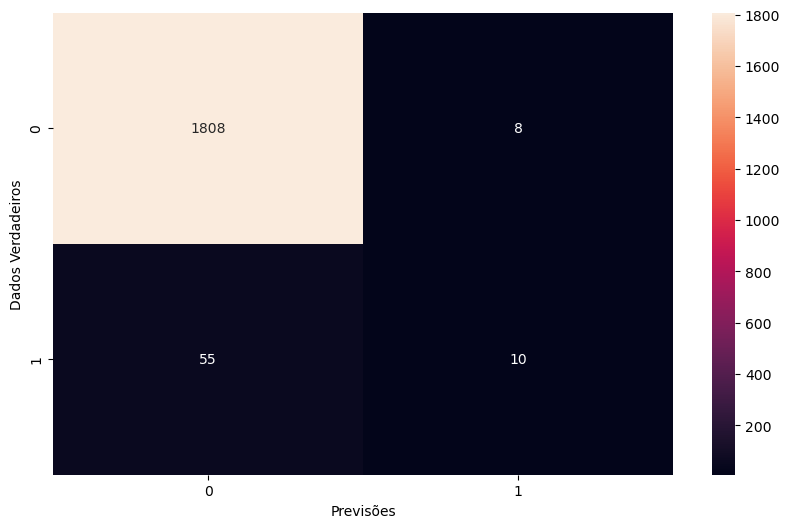

In [53]:
# Vamos por o resultado numa Matriz
print(classification_report(y_test, rfc_rsprev))
matrix_conf(y_test, rfc_rsprev) 

## Random Forest Classifier + GridSearchCV

In [50]:
rfc_gsparams = {'max_features' : ['auto', 'sqrt', 'log2'],
              'random_state' : [42],
              'class_weight' : ['balanced','balanced_subsample'],
              'criterion' : ['gini', 'entropy'],
              'bootstrap' : [True,False]}

grid_rfc = GridSearchCV(RandomForestClassifier(),
                                  rfc_gsparams,
                                  )

gsmodel_rfc = grid_rfc.fit(x_train, y_train)

In [51]:
grid_rfc.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': 'log2',
 'random_state': 42}

In [54]:
tune_grid_rfc = RandomForestClassifier(random_state=42,
               max_features='log2',
                criterion='entropy',
                class_weight='balanced',
                bootstrap=True)

gsmodel2_rfc = tune_grid_rfc.fit(x_train, y_train)
rfc_gsprev = gsmodel2_rfc.predict(x_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1816
           1       0.54      0.11      0.18        65

    accuracy                           0.97      1881
   macro avg       0.75      0.55      0.58      1881
weighted avg       0.95      0.97      0.95      1881



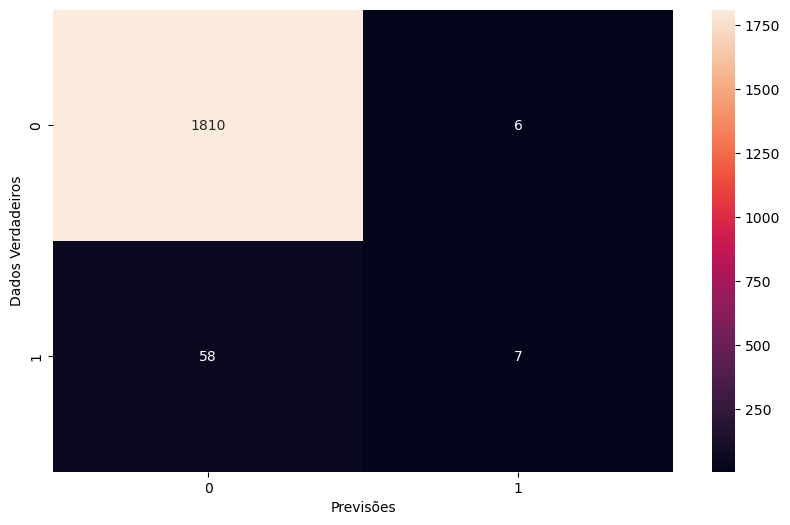

In [55]:
# Vamos por o resultado numa Matriz
print(classification_report(y_test, rfc_gsprev))
matrix_conf(y_test, rfc_gsprev) 

## Desision Tree Classifier + RandomSearchCV

In [56]:
param_rand_dtc = {"max_depth": [None, 3, 5, 10],
                "min_samples_split": np.arange(2, 20, 2),
                "min_samples_leaf": np.arange(1, 20, 2),
                "criterion": ["gini", "entropy"],} 

np.random.seed(42)
modelrs_dtc = RandomizedSearchCV(DecisionTreeClassifier(),
                                param_distributions=param_rand_dtc,
                                cv=5,
                                n_iter=10,
                                verbose=True)

modelrs_dtc.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
                   verbose=True)

In [57]:
modelrs_dtc.best_params_

{'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_depth': 3,
 'criterion': 'entropy'}

In [58]:
param_top_rand_dtc = {"max_depth": [3],
                "min_samples_split": [8],
                "min_samples_leaf": [1],
                "criterion": ["entropy"],} 

np.random.seed(42)
modelrs2_dtc = RandomizedSearchCV(DecisionTreeClassifier(),
                                param_distributions=param_top_rand_dtc,
                                cv=10,
                                n_iter=20,
                                verbose=True)

modelrs2_dtc.fit(x_train, y_train)
dtc_rs_prev = modelrs2_dtc.predict(x_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1816
           1       0.71      0.08      0.14        65

    accuracy                           0.97      1881
   macro avg       0.84      0.54      0.56      1881
weighted avg       0.96      0.97      0.95      1881



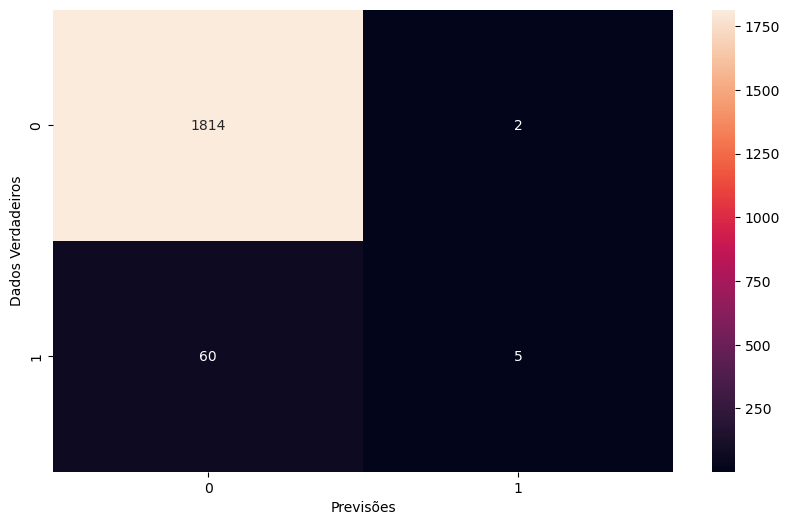

In [59]:
# Vamos por o resultado numa Matriz
print(classification_report(y_test, dtc_rs_prev))
matrix_conf(y_test, dtc_rs_prev) 

## Desision Tree Classifier + GridSearchCV

In [60]:
param_grid_dtc = {"max_depth": [None, 3, 5, 10],
                "min_samples_split": np.arange(2, 10, 2),
                "min_samples_leaf": np.arange(2, 10, 2),
                "criterion": ["gini", "entropy"],} 

np.random.seed(42)
modelgs_dtc = GridSearchCV(DecisionTreeClassifier(),
                                param_grid=param_grid_dtc,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

modelgs_dtc.fit(x_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': array([2, 4, 6, 8]),
                         'min_samples_split': array([2, 4, 6, 8])},
             verbose=True)

In [61]:
modelgs_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [62]:
param_top_grid_dtc = {"max_depth": [3],
                "min_samples_split": [2],
                "min_samples_leaf": [2],
                "criterion": ["entropy"],} 

np.random.seed(42)
modelgs2_dtc = GridSearchCV(DecisionTreeClassifier(),
                                param_grid=param_top_grid_dtc,
                                cv=10,
                                verbose=True,
                                n_jobs=-1)

modelgs2_dtc.fit(x_train, y_train)
dtc_gs_prev = modelgs2_dtc.predict(x_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1816
           1       0.71      0.08      0.14        65

    accuracy                           0.97      1881
   macro avg       0.84      0.54      0.56      1881
weighted avg       0.96      0.97      0.95      1881



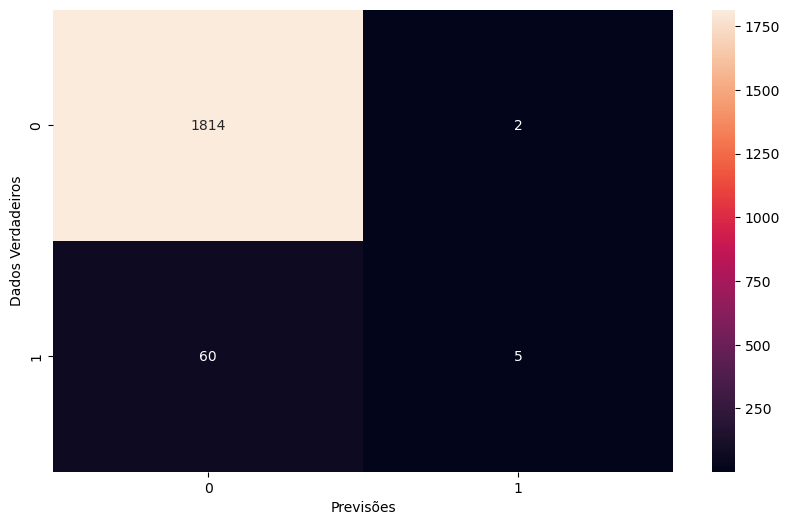

In [63]:
# Vamos por o resultado numa Matriz
print(classification_report(y_test, dtc_gs_prev))
matrix_conf(y_test, dtc_gs_prev) 

## CatBoost Classifier + RandomSearchCV

In [64]:
param_rs_cb = {'eval_metric': ['F1'],
              'iterations': [100,500,1000],
              'learning_rate' : [0.1,0.01,0.001],
              'random_seed' : [42],
              'auto_class_weights' : ['Balanced','SqrtBalanced']
             } 

modelrs_cb = RandomizedSearchCV(CatBoostClassifier(),
                                param_rs_cb,
                                n_iter=4,
                                )

modelrs_cb.fit(x_train, y_train)

0:	learn: 0.8640516	total: 127ms	remaining: 12.6s
1:	learn: 0.8872716	total: 187ms	remaining: 9.16s
2:	learn: 0.9107815	total: 271ms	remaining: 8.76s
3:	learn: 0.9098966	total: 422ms	remaining: 10.1s
4:	learn: 0.9154536	total: 540ms	remaining: 10.3s
5:	learn: 0.9222897	total: 648ms	remaining: 10.2s
6:	learn: 0.9220281	total: 802ms	remaining: 10.7s
7:	learn: 0.9230755	total: 883ms	remaining: 10.1s
8:	learn: 0.9209474	total: 1.06s	remaining: 10.8s
9:	learn: 0.9200272	total: 1.21s	remaining: 10.9s
10:	learn: 0.9266282	total: 1.33s	remaining: 10.8s
11:	learn: 0.9302083	total: 1.57s	remaining: 11.5s
12:	learn: 0.9357422	total: 1.75s	remaining: 11.7s
13:	learn: 0.9350748	total: 1.88s	remaining: 11.6s
14:	learn: 0.9412484	total: 1.98s	remaining: 11.2s
15:	learn: 0.9488181	total: 2.05s	remaining: 10.8s
16:	learn: 0.9456527	total: 2.13s	remaining: 10.4s
17:	learn: 0.9500252	total: 2.2s	remaining: 10s
18:	learn: 0.9511007	total: 2.26s	remaining: 9.64s
19:	learn: 0.9528536	total: 2.34s	remaining:

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x000002668B81DDF0>,
                   n_iter=4,
                   param_distributions={'auto_class_weights': ['Balanced',
                                                               'SqrtBalanced'],
                                        'eval_metric': ['F1'],
                                        'iterations': [100, 500, 1000],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'random_seed': [42]})

In [65]:
modelrs_cb.best_params_

{'random_seed': 42,
 'learning_rate': 0.001,
 'iterations': 100,
 'eval_metric': 'F1',
 'auto_class_weights': 'SqrtBalanced'}

In [69]:
modelrs2_cb = CatBoostClassifier(random_seed=42,
                                 learning_rate=0.1,
                                 iterations=100,
                                 eval_metric='F1',
                                 auto_class_weights='Balanced')

modelrs2_cb.fit(x_train, y_train)
cb_rs_prev = modelrs2_cb.predict(x_test)

0:	learn: 0.8441623	total: 181ms	remaining: 18s
1:	learn: 0.8799713	total: 332ms	remaining: 16.3s
2:	learn: 0.8805797	total: 434ms	remaining: 14s
3:	learn: 0.8893501	total: 664ms	remaining: 15.9s
4:	learn: 0.8938947	total: 745ms	remaining: 14.2s
5:	learn: 0.9070712	total: 820ms	remaining: 12.8s
6:	learn: 0.9060260	total: 902ms	remaining: 12s
7:	learn: 0.9003584	total: 973ms	remaining: 11.2s
8:	learn: 0.8967066	total: 1.04s	remaining: 10.5s
9:	learn: 0.9096094	total: 1.16s	remaining: 10.4s
10:	learn: 0.9171295	total: 1.25s	remaining: 10.1s
11:	learn: 0.9197561	total: 1.32s	remaining: 9.7s
12:	learn: 0.9175845	total: 1.41s	remaining: 9.46s
13:	learn: 0.9214449	total: 1.54s	remaining: 9.49s
14:	learn: 0.9286793	total: 1.62s	remaining: 9.18s
15:	learn: 0.9347104	total: 1.78s	remaining: 9.35s
16:	learn: 0.9377439	total: 1.87s	remaining: 9.12s
17:	learn: 0.9385973	total: 1.94s	remaining: 8.82s
18:	learn: 0.9456692	total: 1.99s	remaining: 8.5s
19:	learn: 0.9505680	total: 2.04s	remaining: 8.16

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1816
           1       0.40      0.62      0.48        65

    accuracy                           0.95      1881
   macro avg       0.69      0.79      0.73      1881
weighted avg       0.97      0.95      0.96      1881



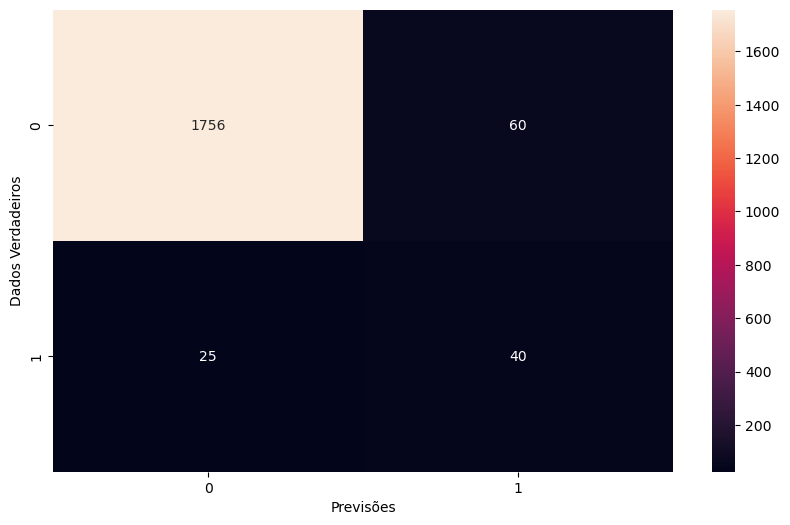

In [70]:
# Vamos por o resultado numa Matriz
print(classification_report(y_test, cb_rs_prev))
matrix_conf(y_test, cb_rs_prev) 

## CatBoost Classifier + GaridSearchCV

In [71]:
param_grid_cb = {'eval_metric': ['F1'],
              'iterations': [100,500,1000],
              'learning_rate' : [0.1,0.01,0.001],
              'random_seed' : [42],
              'auto_class_weights' : ['Balanced','SqrtBalanced']
             }

modelgs_cb = GridSearchCV(CatBoostClassifier(),
                                param_grid=param_grid_cb,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

modelgs_cb.fit(x_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0:	learn: 0.6185804	total: 51.9ms	remaining: 25.9s
1:	learn: 0.6909269	total: 104ms	remaining: 25.8s
2:	learn: 0.6899831	total: 148ms	remaining: 24.5s
3:	learn: 0.6965701	total: 183ms	remaining: 22.6s
4:	learn: 0.7182187	total: 218ms	remaining: 21.6s
5:	learn: 0.7298318	total: 257ms	remaining: 21.1s
6:	learn: 0.7388556	total: 311ms	remaining: 21.9s
7:	learn: 0.7536636	total: 371ms	remaining: 22.8s
8:	learn: 0.7463319	total: 486ms	remaining: 26.5s
9:	learn: 0.7669687	total: 587ms	remaining: 28.8s
10:	learn: 0.7797259	total: 663ms	remaining: 29.5s
11:	learn: 0.7633715	total: 710ms	remaining: 28.9s
12:	learn: 0.7850412	total: 754ms	remaining: 28.2s
13:	learn: 0.7929686	total: 799ms	remaining: 27.7s
14:	learn: 0.8045764	total: 884ms	remaining: 28.6s
15:	learn: 0.8123456	total: 931ms	remaining: 28.2s
16:	learn: 0.8155741	total: 982ms	remaining: 27.9s
17:	learn: 0.8218580	total: 1.04s	remaining: 27.8s
18:	learn: 0.8213144	total: 1.

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002668EAD60D0>,
             n_jobs=-1,
             param_grid={'auto_class_weights': ['Balanced', 'SqrtBalanced'],
                         'eval_metric': ['F1'], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'random_seed': [42]},
             verbose=True)

In [72]:
modelgs_cb.best_params_

{'auto_class_weights': 'SqrtBalanced',
 'eval_metric': 'F1',
 'iterations': 500,
 'learning_rate': 0.1,
 'random_seed': 42}

In [79]:
modelgs2_cb = CatBoostClassifier(random_seed=42,
                                 learning_rate=0.1,
                                 iterations=100,
                                 eval_metric='F1',
                                 auto_class_weights='SqrtBalanced')

modelgs2_cb.fit(x_train, y_train)
cb_gs_prev = modelgs2_cb.predict(x_test)

0:	learn: 0.6185804	total: 129ms	remaining: 12.8s
1:	learn: 0.6909269	total: 241ms	remaining: 11.8s
2:	learn: 0.6899831	total: 294ms	remaining: 9.52s
3:	learn: 0.6965701	total: 347ms	remaining: 8.33s
4:	learn: 0.7182187	total: 442ms	remaining: 8.4s
5:	learn: 0.7298318	total: 525ms	remaining: 8.22s
6:	learn: 0.7388556	total: 581ms	remaining: 7.71s
7:	learn: 0.7536636	total: 674ms	remaining: 7.75s
8:	learn: 0.7463319	total: 727ms	remaining: 7.35s
9:	learn: 0.7669687	total: 777ms	remaining: 6.99s
10:	learn: 0.7797259	total: 833ms	remaining: 6.74s
11:	learn: 0.7633715	total: 894ms	remaining: 6.55s
12:	learn: 0.7850412	total: 953ms	remaining: 6.38s
13:	learn: 0.7929686	total: 991ms	remaining: 6.09s
14:	learn: 0.8045764	total: 1.03s	remaining: 5.83s
15:	learn: 0.8123456	total: 1.09s	remaining: 5.74s
16:	learn: 0.8155741	total: 1.17s	remaining: 5.71s
17:	learn: 0.8218580	total: 1.22s	remaining: 5.57s
18:	learn: 0.8213144	total: 1.28s	remaining: 5.45s
19:	learn: 0.8213144	total: 1.33s	remainin

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1816
           1       0.52      0.37      0.43        65

    accuracy                           0.97      1881
   macro avg       0.75      0.68      0.71      1881
weighted avg       0.96      0.97      0.96      1881



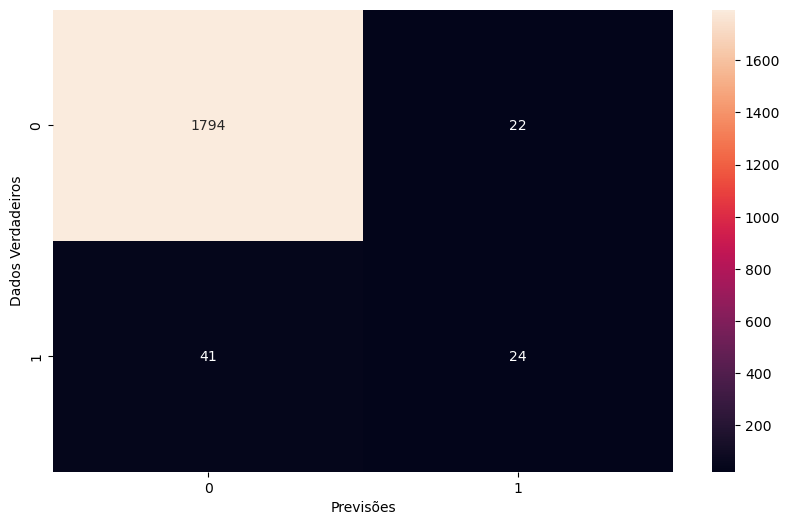

In [80]:
# Vamos por o resultado numa Matriz
print(classification_report(y_test, cb_gs_prev))
matrix_conf(y_test, cb_gs_prev) 

## XGBoost Classifier

In [81]:
# Aqui temos parâmetros aleátorios para o XGBoost Classifier.
random_xgb_param={
    'objective': 'binary:logistic', 
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel' : 1,
    'colsample_bynode' : 1,
    'colsample_bytree' : 1,
    'enable_categorical': False,
    'gamma': hp.uniform('gamma', 0,10),
    'gpu_id': -1,
    'importance_type': None,
    'interaction_constraints': '', 
    'learning_rate': 0.300000012, 
    'max_delta_step': 0,
    'max_depth': hp.randint("max_depth", 10)+3,
    'min_child_weight' : hp.randint('min_child_weight', 4)+1,
    'monotone_constraints': '()',
    'n_estimators': hp.randint('n_estimators', 150)+50,
    'n_jobs': -1,
    'num_parallel_tree':1, 
    'predictor':'auto', 
    'random_state': 0,
    'reg_alpha' : hp.randint('reg_alpha', 10),
    'reg_lambda' : hp.randint('reg_lambda', 10),
    'scale_pos_weight': 1,
    'subsample': 1,
    'tree_method': 'exact',
    'validate_parameters':1,
    'verbosity': None,
    'eval_metric': 'aucpr',
    'eval_metric': "auc",
    'early_stopping_rounds': 10
    }

In [82]:
# Vamos criar uma função para rodar nosso modelo com os parametros do dicionário
def xgb_func(random_param):
        model_xgb= XGBClassifier(**random_param)

        np.random.seed(42)
        valor = [( x_train, y_train), ( x_test, y_test)]

        # Treinamos o modelo
        model_xgb.fit(x_train, y_train,
                eval_set=valor,
                verbose=False)

        # Rodamos o modelo para obter as previsões
        xgb_prev = model_xgb.predict(x_test)
        accuracy = accuracy_score(y_test, xgb_prev>0.5)
        print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }

In [83]:
# Aqui vamos rodar nossa função e colher os melhores parâmetros para o tuning do XGBoost
tentativa = Trials()
best_param = fmin(fn = xgb_func,
                        space = random_xgb_param,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = tentativa)

SCORE:                                                 
0.9702286018075492                                     
SCORE:                                                                            
0.9707602339181286                                                                
SCORE:                                                                            
0.9707602339181286                                                                
SCORE:                                                                            
0.9686337054758107                                                                
SCORE:                                                                            
0.9675704412546517                                                                
SCORE:                                                                            
0.9654439128123339                                                                
SCORE:                                                    

In [84]:
best_param


{'gamma': 0.04956569671963784,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 117,
 'reg_alpha': 6,
 'reg_lambda': 5}

In [85]:
# Aqui temos parâmetros aleátorios para o XGBoostClassifier.
model_xgb = XGBClassifier(
    objective= 'binary:logistic',
    base_score= 0.5, 
    booster= 'gbtree', 
    colsample_bylevel= 1, 
    colsample_bynode= 1, 
    colsample_bytree= 1, 
    enable_categorical= False, 
    gamma= best_param['gamma'], 
    gpu_id= -1, 
    importance_type= None, 
    interaction_constraints= '', 
    learning_rate= 0.300000012, 
    max_delta_step= 0, 
    max_depth= 8, 
    min_child_weight= best_param['min_child_weight'], 
    monotone_constraints= '()',
    n_estimators= best_param['n_estimators'], 
    n_jobs= 4, 
    num_parallel_tree= 1, 
    predictor= 'auto', 
    random_state= 42, 
    reg_alpha= best_param['reg_alpha'], 
    reg_lambda= best_param['reg_lambda'], 
    scale_pos_weight= 1, 
    subsample= 1, 
    tree_method= 'exact', 
    validate_parameters= 1, 
    verbosity= None, 
    eval_metric= 'aucpr'
)

In [86]:
xgb_final = model_xgb.fit(x_train, y_train)
xgb_prevs = model_xgb.predict(x_test)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1816
           1       0.56      0.29      0.38        65

    accuracy                           0.97      1881
   macro avg       0.77      0.64      0.68      1881
weighted avg       0.96      0.97      0.96      1881



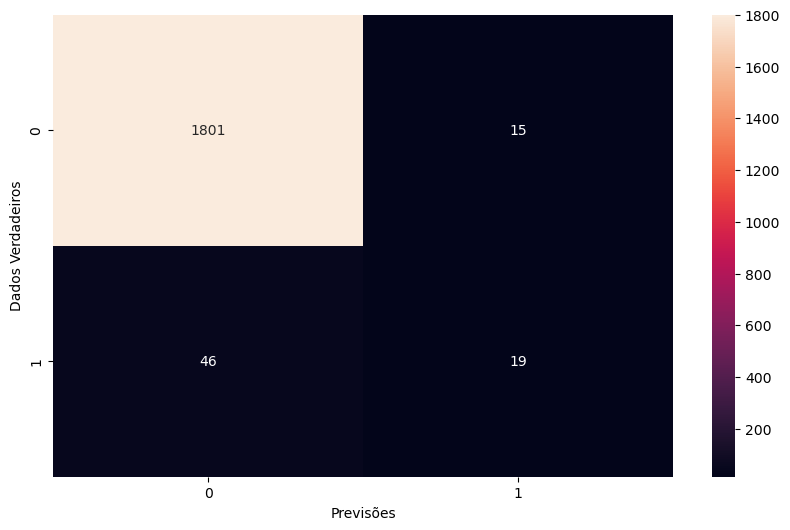

In [87]:
# Vamos por o resultado numa Matriz
print(classification_report(y_test, xgb_prevs))
matrix_conf(y_test, xgb_prevs) 

## Avaliação Final dos Modelos

* Com os modelos finalizados, vamos por os resultados lado a lado, e ver o que conseguimos com os algoritmos de ML usados aqui.

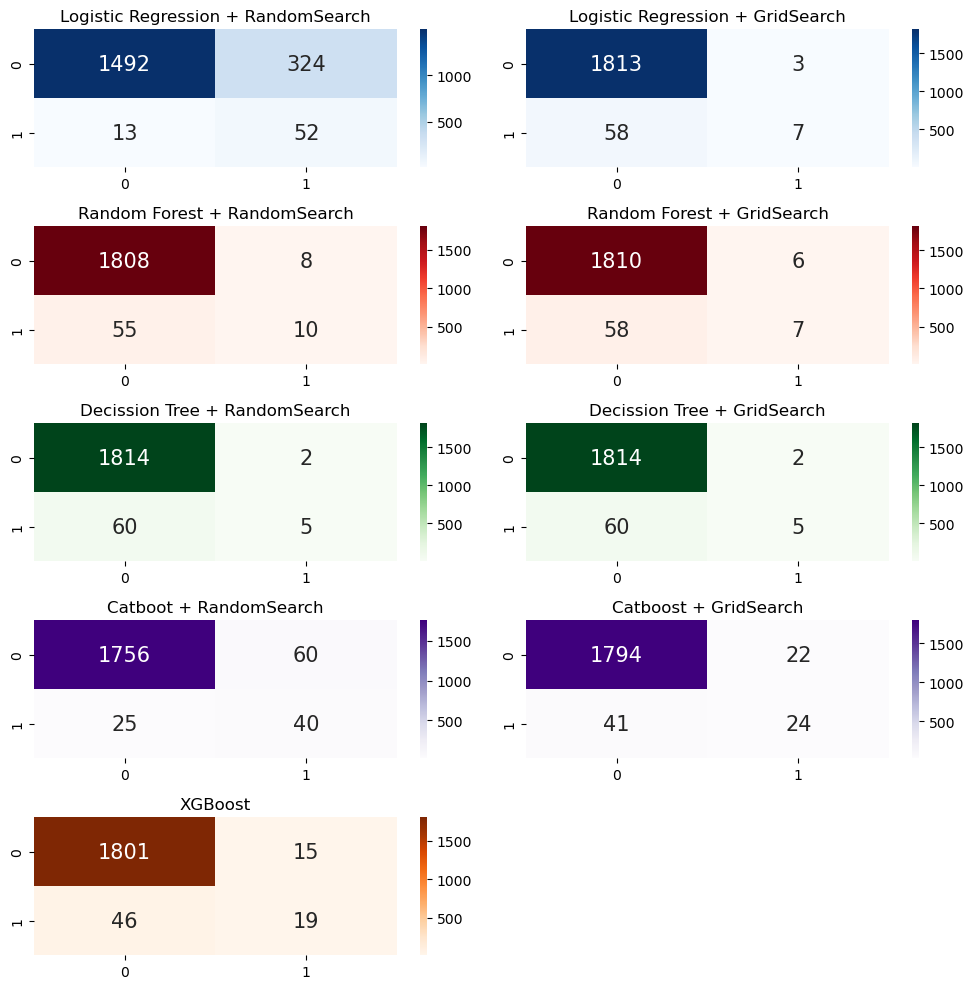

In [88]:
mx_conf0 = confusion_matrix(y_test, log_reg_rsprev)
mx_conf1 = confusion_matrix(y_test, log_reg_gsprev)
mx_conf2 = confusion_matrix(y_test, rfc_rsprev)
mx_conf3 = confusion_matrix(y_test, rfc_gsprev)
mx_conf4 = confusion_matrix(y_test, dtc_rs_prev)
mx_conf5 = confusion_matrix(y_test, dtc_gs_prev)
mx_conf6 = confusion_matrix(y_test, cb_rs_prev)
mx_conf7 = confusion_matrix(y_test, cb_gs_prev)
mx_conf8 = confusion_matrix(y_test, xgb_prevs)

heat_cm0 = pd.DataFrame(mx_conf0, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm1 = pd.DataFrame(mx_conf1, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm2 = pd.DataFrame(mx_conf2, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm3 = pd.DataFrame(mx_conf3, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm4 = pd.DataFrame(mx_conf4, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm5 = pd.DataFrame(mx_conf5, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm6 = pd.DataFrame(mx_conf6, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm7 = pd.DataFrame(mx_conf7, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm8 = pd.DataFrame(mx_conf8, columns=np.unique(y_test), index = np.unique(y_test))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plt.subplot(5,2,1)
sns.heatmap(heat_cm0, cmap="Blues", annot=True, annot_kws={"size": 15},
            fmt='g',).set(title='Logistic Regression + RandomSearch')
plt.subplot(5,2,2)
sns.heatmap(heat_cm1, cmap="Blues", annot=True, annot_kws={"size": 15},
            fmt='g',).set(title='Logistic Regression + GridSearch')
plt.subplot(5,2,3)
sns.heatmap(heat_cm2, cmap="Reds", annot=True, annot_kws={"size": 15},
             fmt='g',).set(title='Random Forest + RandomSearch')
plt.subplot(5,2,4)
sns.heatmap(heat_cm3, cmap="Reds", annot=True, annot_kws={"size": 15},
            fmt='g',).set(title='Random Forest + GridSearch')
plt.subplot(5,2,5)
sns.heatmap(heat_cm4, cmap="Greens", annot=True, annot_kws={"size": 15},
            fmt='g',).set(title='Decission Tree + RandomSearch')
plt.subplot(5,2,6)
sns.heatmap(heat_cm5, cmap="Greens", annot=True, annot_kws={"size": 15},
            fmt='g',).set(title='Decission Tree + GridSearch')
plt.subplot(5,2,7)
sns.heatmap(heat_cm6, cmap="Purples", annot=True, annot_kws={"size": 15},
            fmt='g',).set(title='Catboot + RandomSearch')
plt.subplot(5,2,8)
sns.heatmap(heat_cm7, cmap="Purples", annot=True, annot_kws={"size": 15},
            fmt='g',).set(title='Catboost + GridSearch')
plt.subplot(5,2,9)
sns.heatmap(heat_cm8, cmap="Oranges", annot=True, annot_kws={"size": 15},
            fmt='g',).set(title='XGBoost')
plt.tight_layout()


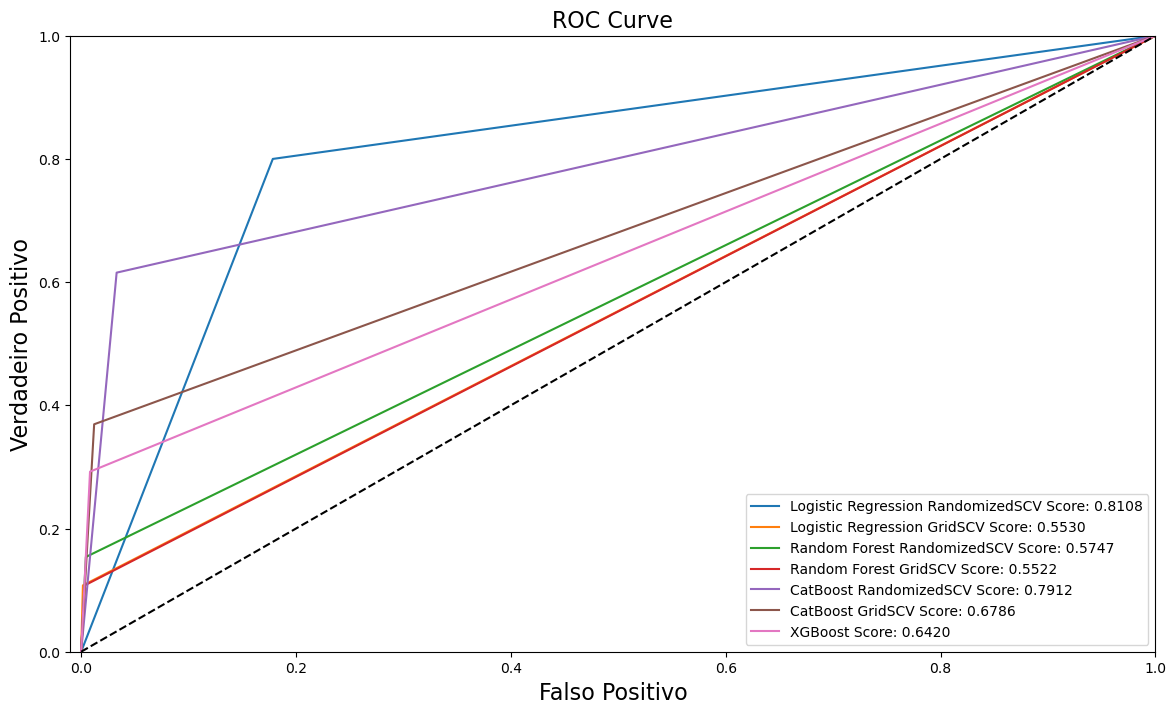

In [89]:
log_fpr1, log_tpr1, log_thresold1 = roc_curve(y_test, log_reg_rsprev)
log_fpr2, log_tpr2, log_thresold2 = roc_curve(y_test, log_reg_gsprev)
rfc_fpr1, rfc_tpr1, rfc_threshold1 = roc_curve(y_test, rfc_rsprev)
rfc_fpr2, rfc_tpr2, rfc_threshold2 = roc_curve(y_test, rfc_gsprev)
xgb_fpr, xgb_tpr, xgb_thresold = roc_curve(y_test, xgb_prevs)
cb_fpr1, cb_tpr1, cat_thresold1 = roc_curve(y_test, cb_rs_prev)
cb_fpr2, cb_tpr2, cat_thresold2 = roc_curve(y_test, cb_gs_prev)


def graph_roc_curve_multiple(log_fpr1, log_tpr1, log_fpr2, log_tpr2,
                             rfc_fpr1, rfc_tpr1, rfc_fpr2, rfc_tpr2,
                             cb_fpr1, cb_tpr1, cb_fpr2, cb_tpr2,
                                xgb_fpr, xgb_tpr):
    plt.figure(figsize=(14,8))
    plt.title('ROC Curve', fontsize=16)
    plt.plot(log_fpr1, log_tpr1, label='Logistic Regression RandomizedSCV Score: {:.4f}'.format(roc_auc_score(y_test, log_reg_rsprev)))
    plt.plot(log_fpr2, log_tpr2, label='Logistic Regression GridSCV Score: {:.4f}'.format(roc_auc_score(y_test, log_reg_gsprev)))
    plt.plot(rfc_fpr1, rfc_tpr1, label='Random Forest RandomizedSCV Score: {:.4f}'.format(roc_auc_score(y_test, rfc_rsprev)))
    plt.plot(rfc_fpr2, rfc_tpr2, label='Random Forest GridSCV Score: {:.4f}'.format(roc_auc_score(y_test, rfc_gsprev)))
    plt.plot(cb_fpr1, cb_tpr1, label='CatBoost RandomizedSCV Score: {:.4f}'.format(roc_auc_score(y_test, cb_rs_prev)))
    plt.plot(cb_fpr2, cb_tpr2, label='CatBoost GridSCV Score: {:.4f}'.format(roc_auc_score(y_test, cb_gs_prev)))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Score: {:.4f}'.format(roc_auc_score(y_test, xgb_prevs)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('Falso Positivo', fontsize=16)
    plt.ylabel('Verdadeiro Positivo', fontsize=16)
    plt.legend()
    

graph_roc_curve_multiple(log_fpr1, log_tpr1, log_fpr2, log_tpr2,
                 rfc_fpr1, rfc_tpr1, rfc_fpr2, rfc_tpr2,
                   cb_fpr1, cb_tpr1, cb_fpr2, cb_tpr2,
                     xgb_fpr, xgb_tpr)
plt.show()

* Modelos completos, e pelo que podemos observar aqui, eles têm sérios problemas para identificar empresas próximas de uma situação de falência. O algoritmo que entregou os melhores resultados, foi o de Logistic Regression, apesar da imprecisão demonstrada na alta contagem de falsos negativos.
* Outro algoritmo que performou de forma razoável, foi o CatBoost, apesar de uma alta contagem de falsos positivos, apresentou uma contagem baixa de falsos negativos.
* Vamos olhar os dois mais de perto.

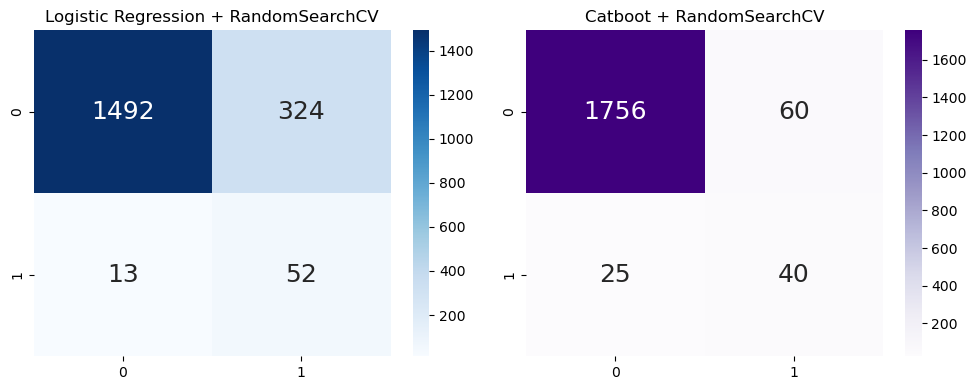

In [90]:
fig, axs = plt.subplots(2, 2, figsize=(10, 4))
plt.subplot(1,2,1)
sns.heatmap(heat_cm0, cmap="Blues", annot=True, annot_kws={"size": 18},
            fmt='g',).set(title='Logistic Regression + RandomSearchCV')
plt.subplot(1,2,2)
sns.heatmap(heat_cm6, cmap="Purples", annot=True, annot_kws={"size": 18},
            fmt='g',).set(title='Catboot + RandomSearchCV')
plt.tight_layout()

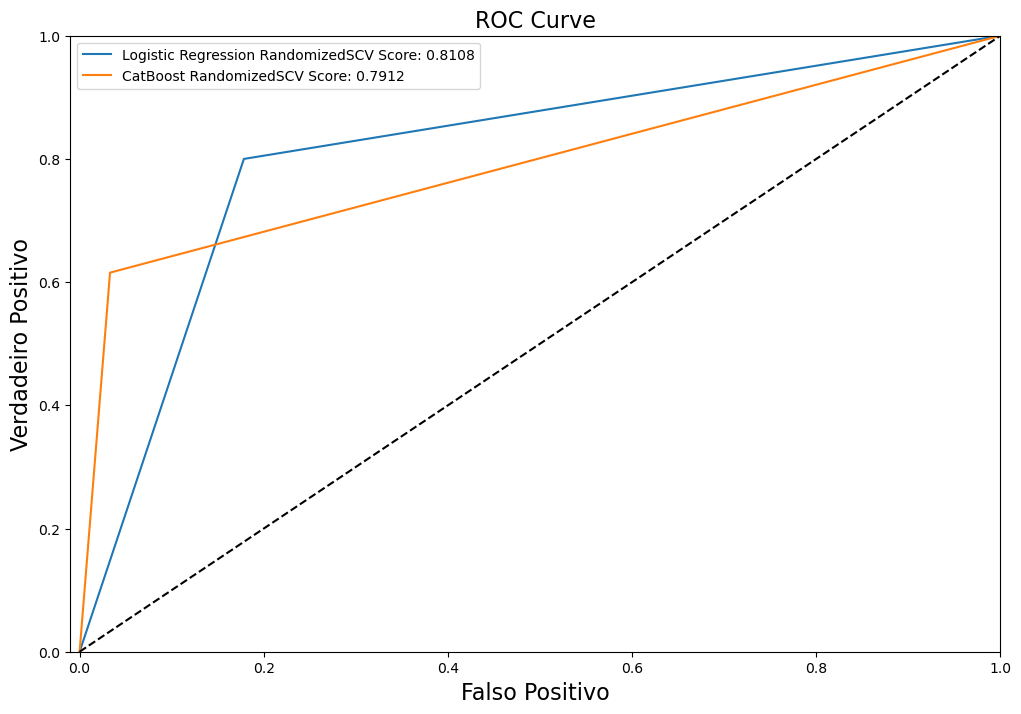

In [91]:
def graph_roc_curve_multiple(log_fpr1, log_tpr1, cb_fpr1, cb_tpr1):
    plt.figure(figsize=(12,8))
    plt.title('ROC Curve', fontsize=16)
    plt.plot(log_fpr1, log_tpr1, label='Logistic Regression RandomizedSCV Score: {:.4f}'.format(roc_auc_score(y_test, log_reg_rsprev)))
    plt.plot(cb_fpr1, cb_tpr1, label='CatBoost RandomizedSCV Score: {:.4f}'.format(roc_auc_score(y_test, cb_rs_prev)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('Falso Positivo', fontsize=16)
    plt.ylabel('Verdadeiro Positivo', fontsize=16)
    plt.legend()
    

graph_roc_curve_multiple(log_fpr1, log_tpr1, cb_fpr1, cb_tpr1)
plt.show()

In [92]:
print(8*'-','Logistic Regression + RandomizedSearchCV',8*'-')
print(classification_report(y_test, log_reg_rsprev))
print('')
print(13*'-','CatBoost + RandomizedSearchCV',13*'-')
print(classification_report(y_test, cb_rs_prev))

-------- Logistic Regression + RandomizedSearchCV --------
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1816
           1       0.14      0.80      0.24        65

    accuracy                           0.82      1881
   macro avg       0.56      0.81      0.57      1881
weighted avg       0.96      0.82      0.88      1881


------------- CatBoost + RandomizedSearchCV -------------
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1816
           1       0.40      0.62      0.48        65

    accuracy                           0.95      1881
   macro avg       0.69      0.79      0.73      1881
weighted avg       0.97      0.95      0.96      1881



* Apesar da presença de erros relevantes, o melhor modelo a se adotar aqui é o de Logistic Regression, uma vez que devido à natureza do projeto, tem um melhor proveito prático. A alta presença de falsos negativos é um erro aceitável, uma vez que um falso alerta de falência, causaria pouco ou nenhum impacto nas empresas em questão. Então acredito que o modelo construído aqui é útil e serviu ao proposito do projeto.
* Vamos dar uma olhada nas principais categorias que influenciaram o modelo.

## Avaliação das Categorias

In [93]:
print(modelrs2_log_reg.coef_)

[[-6.13096901e+00 -4.90397169e+00 -4.35744263e+00  1.89951486e-01
   1.94837145e-01  9.40475672e-01  7.80630894e-01  7.90761636e-01
   3.25500005e-01  7.66475455e-01  1.63800663e-03  2.32508928e-03
   1.95567913e-01 -2.36026006e-02 -6.10256350e+00 -1.71889977e+00
  -1.71742682e+00 -1.71866370e+00 -2.21711308e+00 -4.20598832e-02
  -1.87085519e+00 -1.36659230e+00 -2.09956363e+00  8.08401966e-02
   7.89751637e-01  5.63767213e-01  5.68564504e-01  2.10124810e-01
   5.19556590e-02 -1.20966202e-02  2.69734962e-01 -1.60855029e-01
  -7.92649847e-01 -4.13729890e-02  6.36350069e-01  2.03896156e+00
   4.98146423e+00 -2.14454385e+00  1.40433329e-01  1.32182011e+00
   3.74629552e-01 -1.34302650e+00 -2.03004517e+00  7.34434024e-01
  -1.76796357e+00 -2.00714634e+00 -4.99346610e-01 -1.30064625e-02
   2.59138631e-02  4.55223555e-01  2.04183298e+00 -4.84239054e-01
  -5.39206879e-01 -2.69164560e+00 -7.11469748e-01  1.67119415e+00
  -2.09070246e+00 -9.53250663e-01  6.31342751e-02  4.16454556e+00
  -2.99341

<AxesSubplot:ylabel='Categorias'>

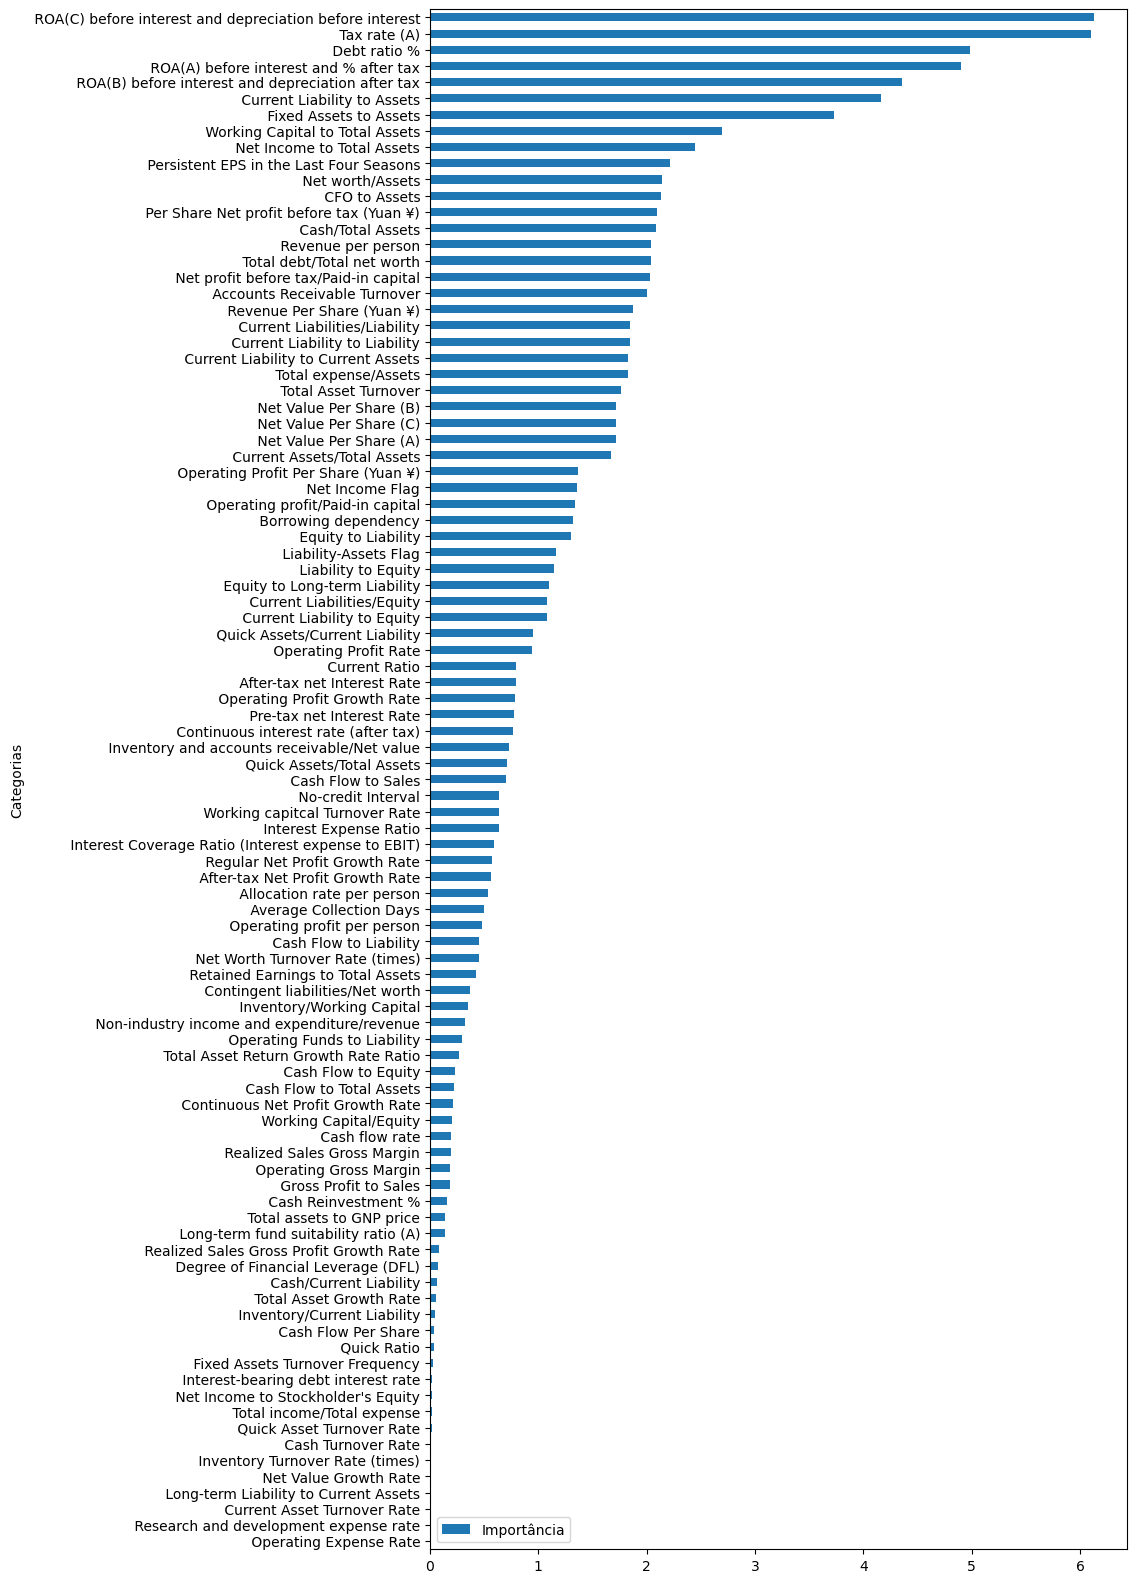

In [97]:
coeff = modelrs2_log_reg.coef_[0]

feature_importance = pd.DataFrame({'Categorias': x_test.columns, 'Importância': np.abs(coeff)})
feature_importance = feature_importance.sort_values('Importância', ascending=True)
feature_importance.plot(x='Categorias', y='Importância', kind='barh', figsize=(9, 20))

* Fica bem claro no gráfico o peso que o retorno sobre os ativos tem nesses dados. Esses dados aparecem no topo da relevância para o modelo, seja pré-depreciação, pós e pré-impostos.
* Seguindo os retorno sobre ativos, temos taxas de débito e impostos, seguido de passivos circulantes. 